In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.gridspec import GridSpec
import seaborn as sns 
%matplotlib inline 
from matplotlib import rc
rc('font', family = 'AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
from plotly.subplots import make_subplots
import plotly.graph_objects as go
plt.style.use(['ggplot'])


import warnings
warnings.filterwarnings(action='ignore')

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

pd.options.display.float_format = '{:.0f}'.format
pd.options.display.max_rows=1000
        
# seed 설정
np.random.seed(42)

#model 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgbm

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.shape

(26457, 20)

In [4]:
test.shape

(10000, 19)

In [5]:
data = pd.concat([train, test], axis=0)
data

index gender car reality  child_num  income_total           income_type  \
0         0      F   N       N          0        202500  Commercial associate   
1         1      F   N       Y          1        247500  Commercial associate   
2         2      M   Y       Y          0        450000               Working   
3         3      F   N       Y          0        202500  Commercial associate   
4         4      F   Y       Y          0        157500         State servant   
...     ...    ...  ..     ...        ...           ...                   ...   
9995  36452      F   Y       Y          0        202500               Working   
9996  36453      M   Y       Y          0        202500               Working   
9997  36454      F   N       Y          0        292500               Working   
9998  36455      F   Y       N          0        180000  Commercial associate   
9999  36456      F   N       Y          0        270000               Working   

                           edu_type     family_type           house_type  \
0                  Higher education         Married  Municipal apartment   
1     Secondary / secondary special  Civil marriage    House / apartment   
2                  Higher education         Married    House / apartment   
3     Secondary / secondary special         Married    House / apartment   
4                  Higher education         Married    House / apartment   
...                             ...             ...                  ...   
9995              Incomplete higher         Married    House / apartment   
9996  Secondary / secondary special  Civil marriage    House / apartment   
9997  Secondary / secondary special         Married    House / apartment   
9998  Secondary / secondary special         Married    House / apartment   
9999               Higher education         Married    House / apartment   

      DAYS_BIRTH  DAYS_EMPLOYED  FLAG_MOBIL  work_phone  phone  email  \
0         -13899          -4709           1           0      0      0   
1         -11380          -1540           1           0      0      1   
2         -19087          -4434           1           0      1      0   
3         -15088          -2092           1           0      1      0   
4         -15037          -2105           1           0      0      0   
...          ...            ...         ...         ...    ...    ...   
9995      -18593          -5434           1           1      1      0   
9996      -10886          -1315           1           1      0      0   
9997      -21016         -14018           1           0      0      0   
9998      -16541          -1085           1           0      1      0   
9999       -9154           -187           1           0      0      1   

          occyp_type  family_size  begin_month  credit  
0                NaN            2           -6       1  
1           Laborers            3           -5       1  
2           Managers            2          -22       2  
3        Sales staff            2          -37       0  
4           Managers            2          -26       2  
...              ...          ...          ...     ...  
9995     Accountants            2          -19     NaN  
9996        Laborers            2          -34     NaN  
9997  Medicine staff            2          -55     NaN  
9998             NaN            2          -33     NaN  
9999        Laborers            2          -11     NaN  

[36457 rows x 20 columns]

In [6]:
# 나이로 변환
data['DAYS_BIRTH'] = data['DAYS_BIRTH'].apply(lambda x: (x*-1)/365)
# 근속년수로 변환
data['DAYS_EMPLOYED'] = data['DAYS_EMPLOYED'].apply(lambda x: (x*-1)/365)
# 마이너스 변환
data['begin_month'] = data['begin_month'].apply(lambda x: x*-1)

data

index gender car reality  child_num  income_total           income_type  \
0         0      F   N       N          0        202500  Commercial associate   
1         1      F   N       Y          1        247500  Commercial associate   
2         2      M   Y       Y          0        450000               Working   
3         3      F   N       Y          0        202500  Commercial associate   
4         4      F   Y       Y          0        157500         State servant   
...     ...    ...  ..     ...        ...           ...                   ...   
9995  36452      F   Y       Y          0        202500               Working   
9996  36453      M   Y       Y          0        202500               Working   
9997  36454      F   N       Y          0        292500               Working   
9998  36455      F   Y       N          0        180000  Commercial associate   
9999  36456      F   N       Y          0        270000               Working   

                           edu_type     family_type           house_type  \
0                  Higher education         Married  Municipal apartment   
1     Secondary / secondary special  Civil marriage    House / apartment   
2                  Higher education         Married    House / apartment   
3     Secondary / secondary special         Married    House / apartment   
4                  Higher education         Married    House / apartment   
...                             ...             ...                  ...   
9995              Incomplete higher         Married    House / apartment   
9996  Secondary / secondary special  Civil marriage    House / apartment   
9997  Secondary / secondary special         Married    House / apartment   
9998  Secondary / secondary special         Married    House / apartment   
9999               Higher education         Married    House / apartment   

      DAYS_BIRTH  DAYS_EMPLOYED  FLAG_MOBIL  work_phone  phone  email  \
0             38             13           1           0      0      0   
1             31              4           1           0      0      1   
2             52             12           1           0      1      0   
3             41              6           1           0      1      0   
4             41              6           1           0      0      0   
...          ...            ...         ...         ...    ...    ...   
9995          51             15           1           1      1      0   
9996          30              4           1           1      0      0   
9997          58             38           1           0      0      0   
9998          45              3           1           0      1      0   
9999          25              1           1           0      0      1   

          occyp_type  family_size  begin_month  credit  
0                NaN            2            6       1  
1           Laborers            3            5       1  
2           Managers            2           22       2  
3        Sales staff            2           37       0  
4           Managers            2           26       2  
...              ...          ...          ...     ...  
9995     Accountants            2           19     NaN  
9996        Laborers            2           34     NaN  
9997  Medicine staff            2           55     NaN  
9998             NaN            2           33     NaN  
9999        Laborers            2           11     NaN  

[36457 rows x 20 columns]

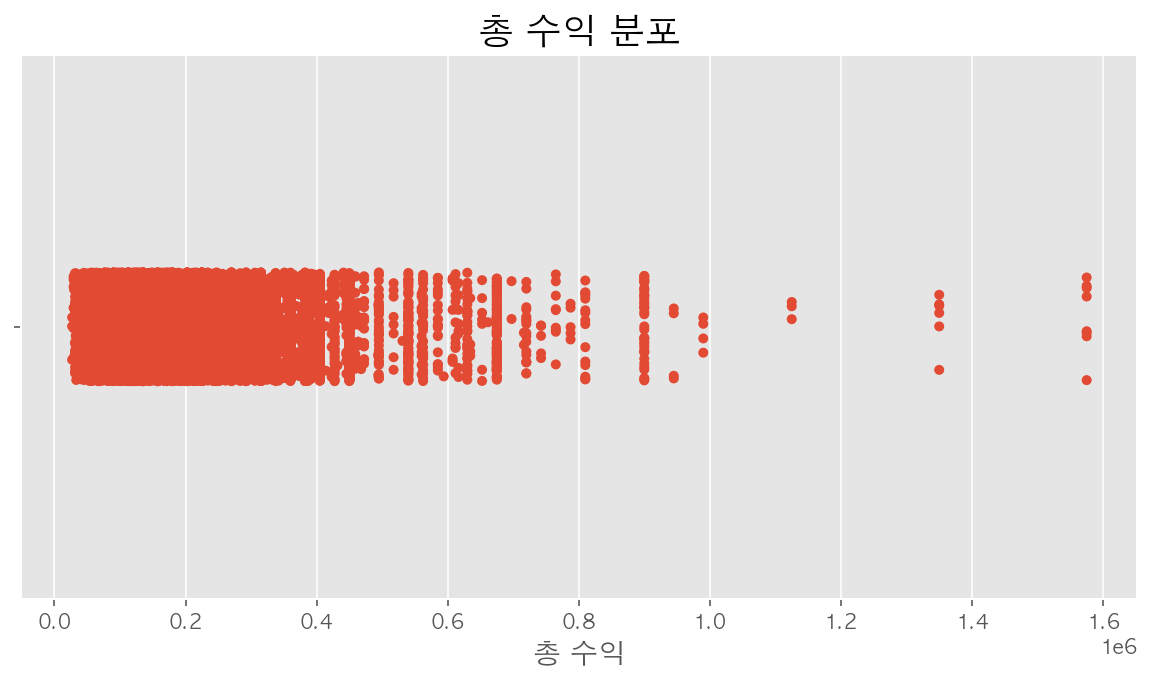

In [7]:
f=plt.figure(figsize=(10,5))
sns.stripplot(x='income_total', data=data)
plt.title('총 수익 분포', fontsize=18)
plt.xlabel('총 수익', fontsize=14);

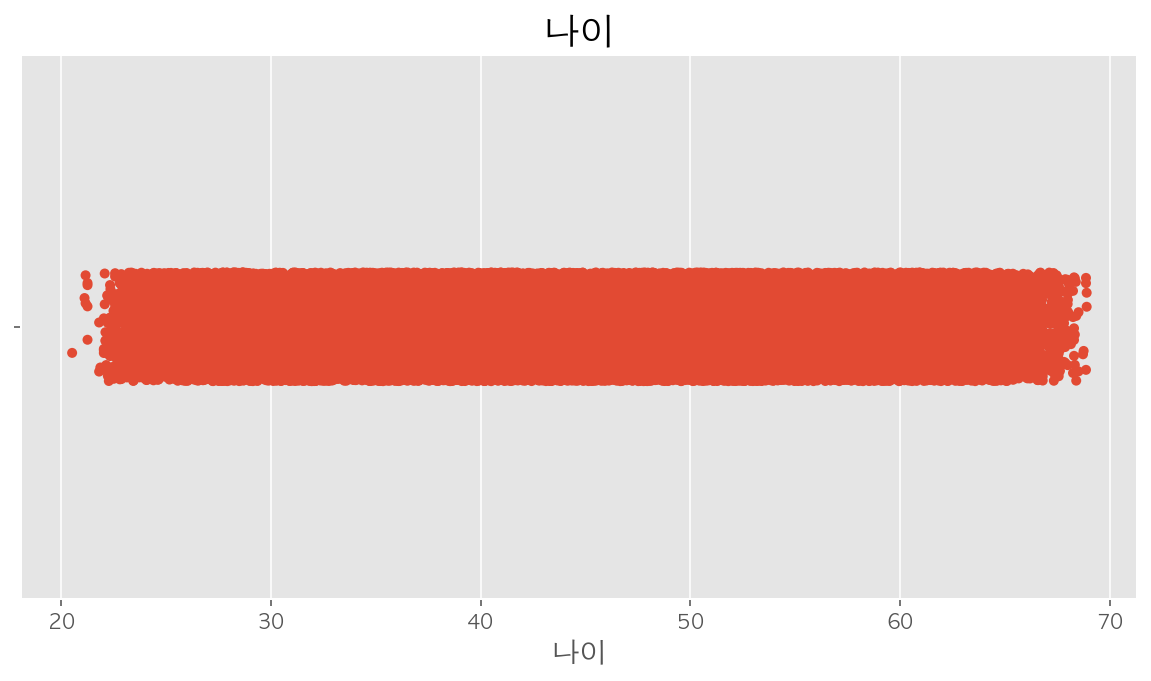

In [8]:
f=plt.figure(figsize=(10,5))
sns.stripplot(x='DAYS_BIRTH', data=data)
plt.title('나이', fontsize=18)
plt.xlabel('나이', fontsize=14);

In [9]:
income_list = [
    (data['DAYS_BIRTH'] <= 35),
    (data['DAYS_BIRTH'] <= 55) & (data['DAYS_BIRTH'] > 35),
    (data['DAYS_BIRTH'] <= 70) & (data['DAYS_BIRTH'] > 55)]

indi_list = ['청년', '중년', '노년']

data['age'] = np.select(income_list, indi_list)

In [10]:
days_list = [
    (data['income_total'] <= 150000),
    (data['income_total'] <= 300000) & (data['income_total'] > 150000),
    (data['income_total'] <= 700000) & (data['income_total'] > 300000),
    (data['income_total'] <= 1600000) & (data['income_total'] > 700000)]

ind_list = ['초저소득층', '저소득층', '중산층', '상류층']

data['class'] = np.select(days_list, ind_list)

In [11]:
income = data['income_type'].value_counts().reset_index()
income

index  income_type
0               Working        18819
1  Commercial associate         8490
2             Pensioner         6152
3         State servant         2985
4               Student           11

In [12]:
clas = data['class'].value_counts().reset_index()
clas

index  class
0   저소득층  17306
1  초저소득층  15322
2    중산층   3710
3    상류층    119

In [13]:
age = data['age'].value_counts().reset_index()
age

index    age
0    중년  18744
1    청년  10026
2    노년   7687

<AxesSubplot:ylabel='class'>

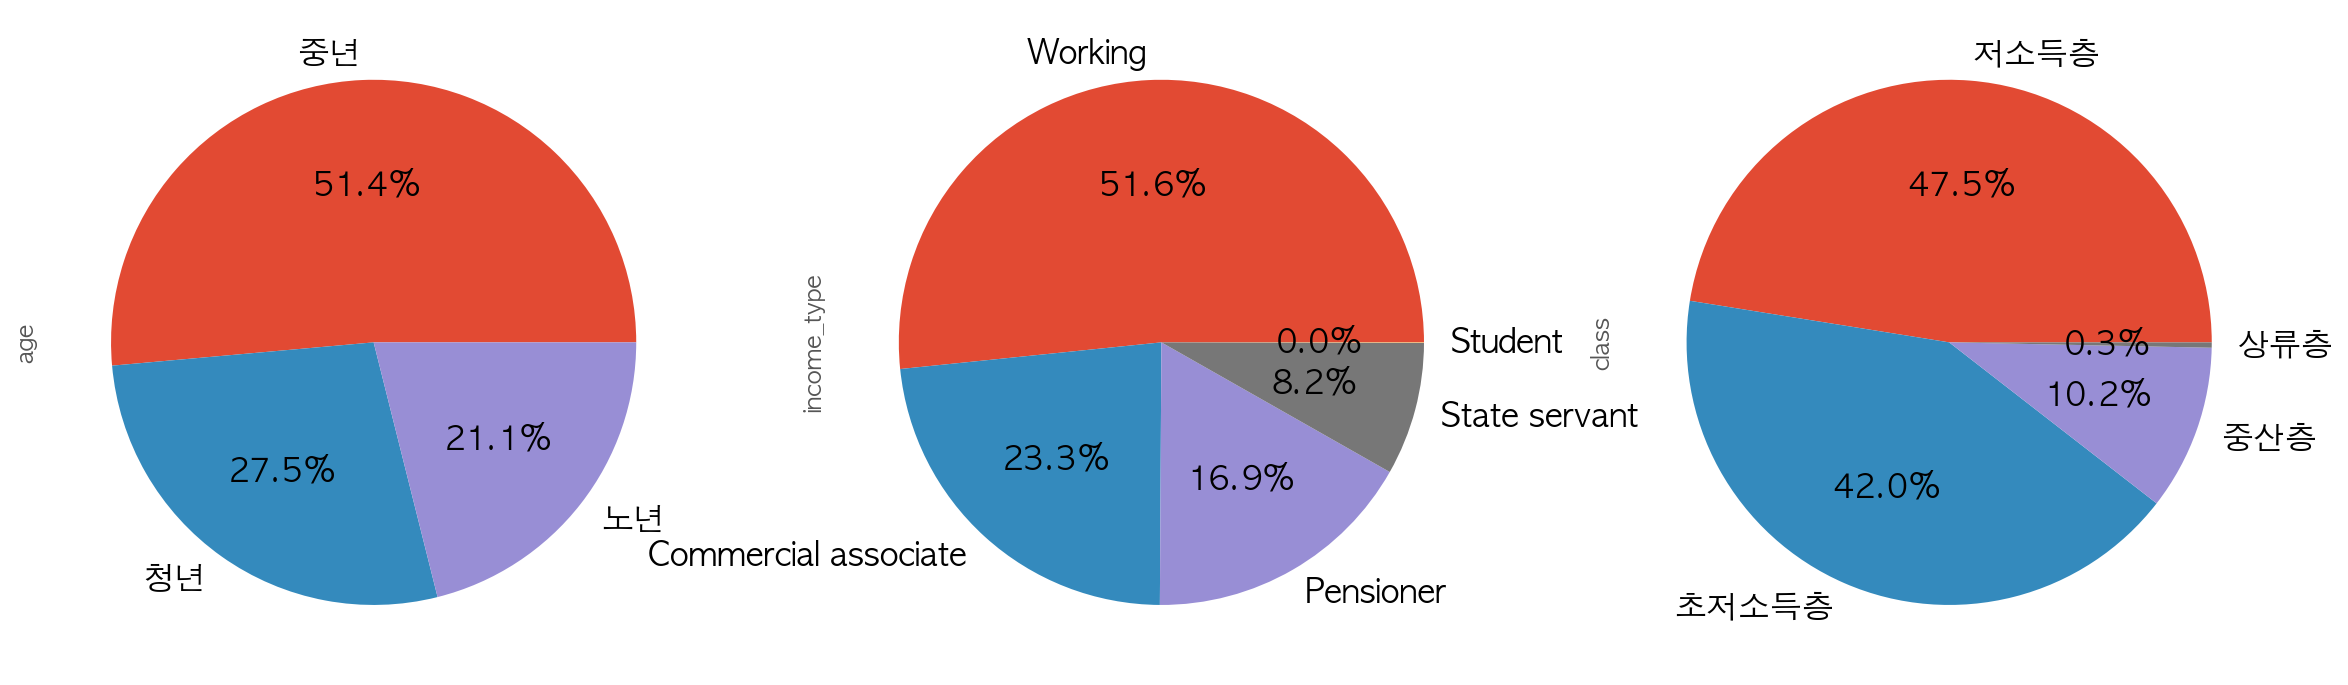

In [14]:
f, ax = plt.subplots(1, 3, figsize = (20,9))
# 파이차트
data['age'].value_counts().plot.pie(autopct = '%1.1f%%', shadow= False, textprops={'fontsize':16}, ax=ax[0])
data['income_type'].value_counts().plot.pie(autopct = '%1.1f%%', shadow= False, textprops={'fontsize':16}, ax=ax[1])
data['class'].value_counts().plot.pie(autopct='%1.1f%%', shadow=False, textprops={'fontsize':16}, ax=ax[2])



<AxesSubplot:xlabel='index', ylabel='class'>

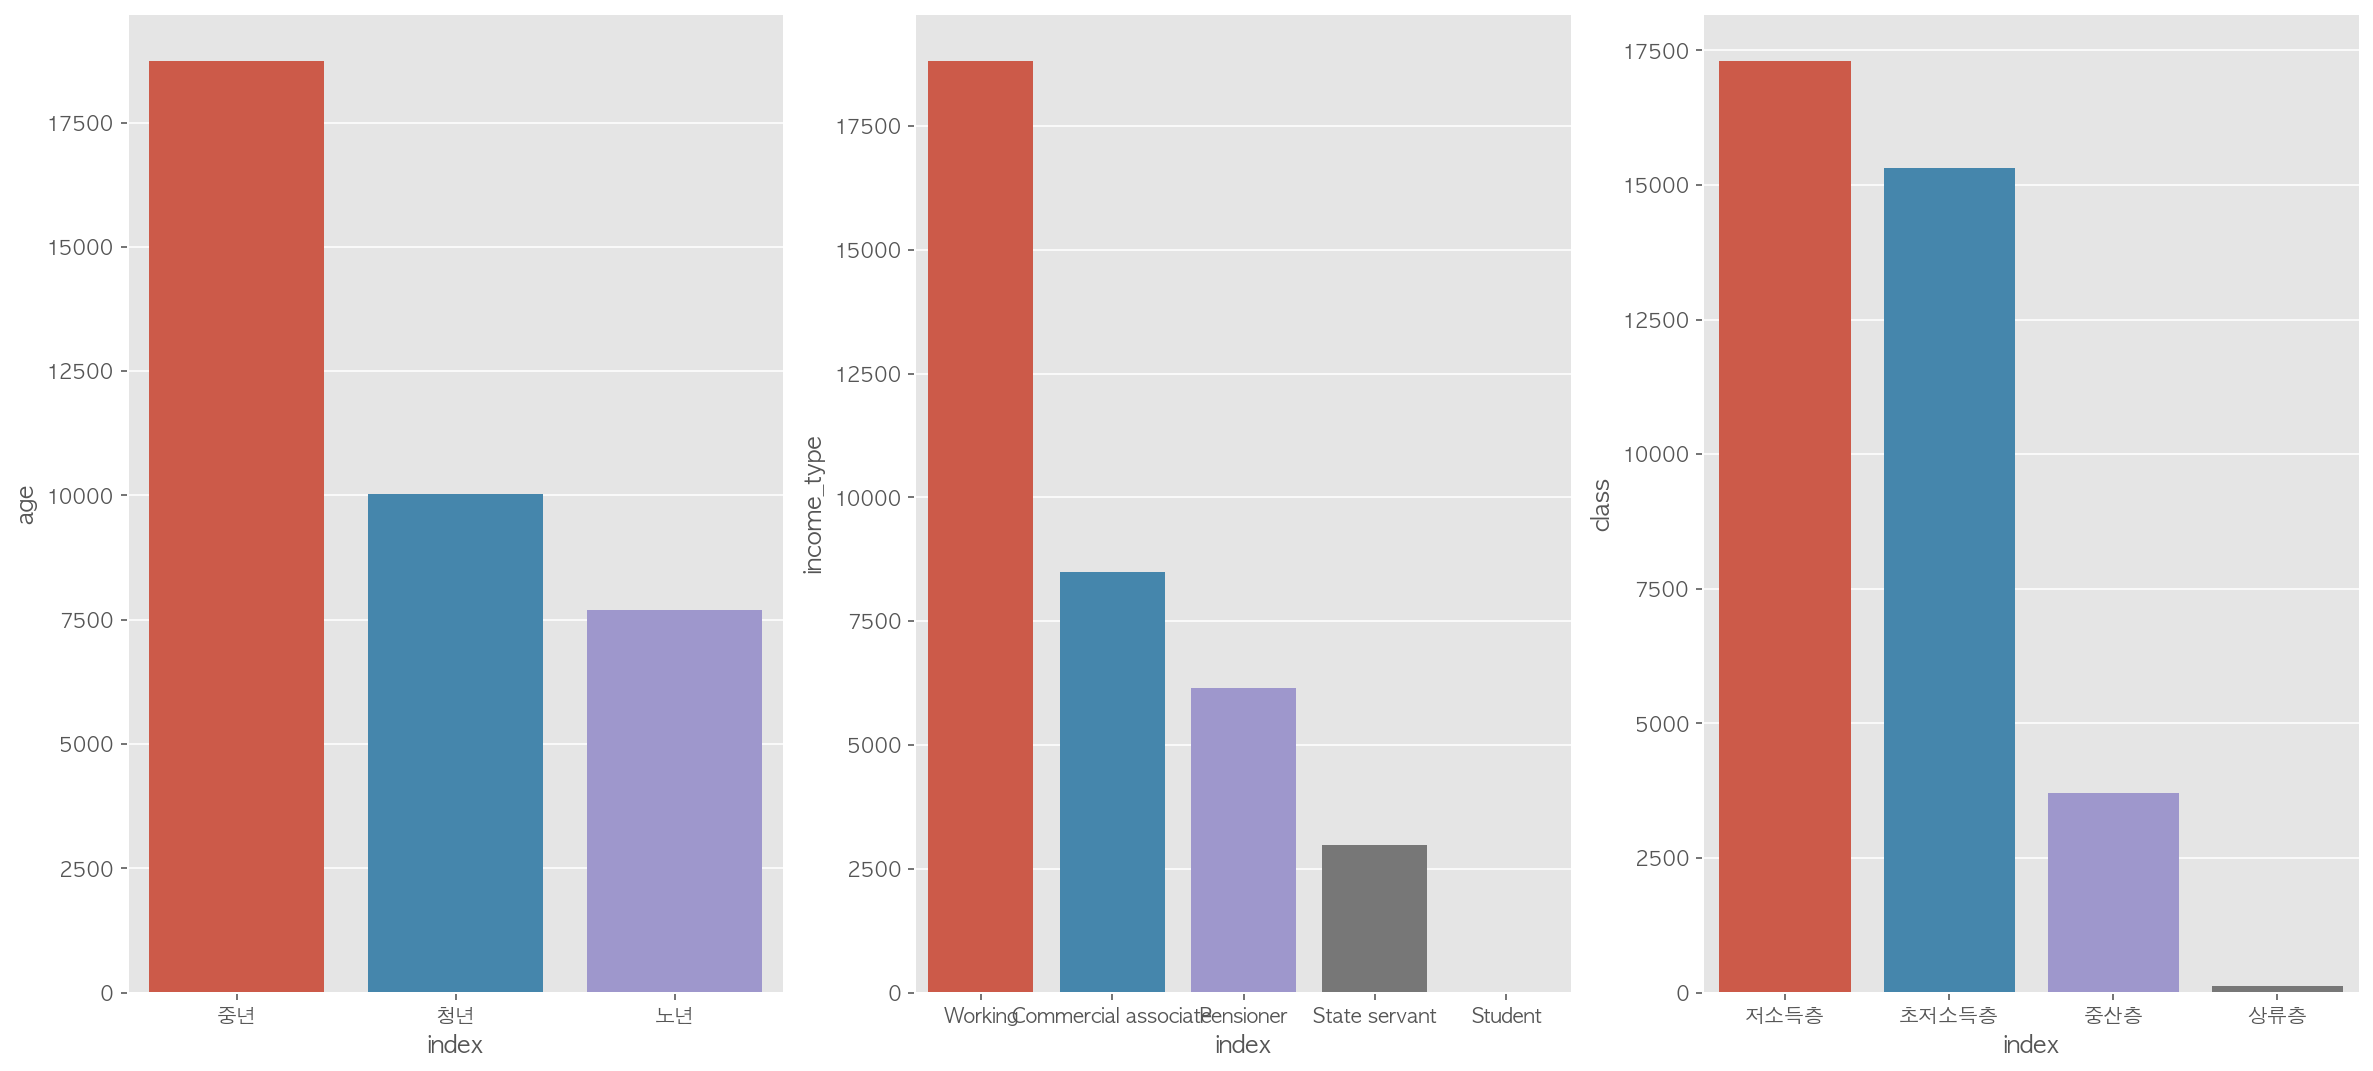

In [15]:
f, ax = plt.subplots(1, 3, figsize = (20,9))
# 막대 그래프
sns.barplot(data=age, x='index', y='age', ax=ax[0])
sns.barplot(data=income, x='index', y='income_type', ax=ax[1])
sns.barplot(data=clas, x='index', y='class', ax=ax[2])

In [16]:
credit = data['credit'].value_counts().reset_index()
credit

index  credit
0      2   16968
1      1    6267
2      0    3222

In [17]:
# 신용듭급에 따라 살펴보기
credit_0 = data[data['credit']==0]
credit_1 = data[data['credit']==1]
credit_2 = data[data['credit']==2]

In [18]:
credit_0['gender'].value_counts().index

Index(['F', 'M'], dtype='object')

In [19]:
# 그래프 만들어주는 함수 정의

def make_plot(column):
    
    ## 파이 차트
    fig = plt.figure(figsize=(30,10))
    fig.set_facecolor('white')

    fig.add_subplot(1,3,1)

    pie1 = plt.pie(credit_0[column].value_counts(),
                   labels=credit_0[column].value_counts(),
                   startangle=90, 
                   shadow=True, 
                   counterclock=False,
                   autopct=lambda p : '{:.2f}%'.format(p),
                   textprops={'fontsize': 25})

    plt.legend(fontsize=20)
    plt.title('credit=0', fontsize=30)

    fig.add_subplot(1,3,2)

    pie2 = plt.pie(credit_1[column].value_counts(),
                   labels=credit_1[column].value_counts(),
                   startangle=90, 
                   shadow=True, 
                   counterclock=False,
                   autopct=lambda p : '{:.2f}%'.format(p),
                   textprops={'fontsize': 25})
    
    plt.legend(fontsize=20)
    plt.title('credit=1', fontsize=30)

    fig.add_subplot(1,3,3)
    pie3 = plt.pie(credit_2[column].value_counts(),
                   labels=credit_2[column].value_counts(),
                   startangle=90, 
                   shadow=True, 
                   counterclock=False,
                   autopct=lambda p : '{:.2f}%'.format(p),
                   textprops={'fontsize': 25})
           
    plt.legend(fontsize=20)
    plt.title('credit=2', fontsize=30)
    plt.show()
    
    ## 막대 그래프
    fig = plt.figure(figsize=(20,5))
    gs = GridSpec(1,3)
    
    sns.countplot(data=credit_0,
                x= column,
                ax = fig.add_subplot(gs[0,0]),
                order=credit_0[column].value_counts().index)
    plt.ylabel('count', fontsize=16)
    plt.title('credit=0', fontsize=20)
    
    sns.countplot(data=credit_1,
                x= column,
                ax = fig.add_subplot(gs[0,1]),
                order=credit_1[column].value_counts().index)
    plt.ylabel('count', fontsize=16)
    plt.title('credit=1', fontsize=20)
    
    sns.countplot(data=credit_2,
                x= column,
                ax = fig.add_subplot(gs[0,2]),
                order=credit_2[column].value_counts().index)
    plt.ylabel('count', fontsize=16)
    plt.title('credit=2', fontsize=20)

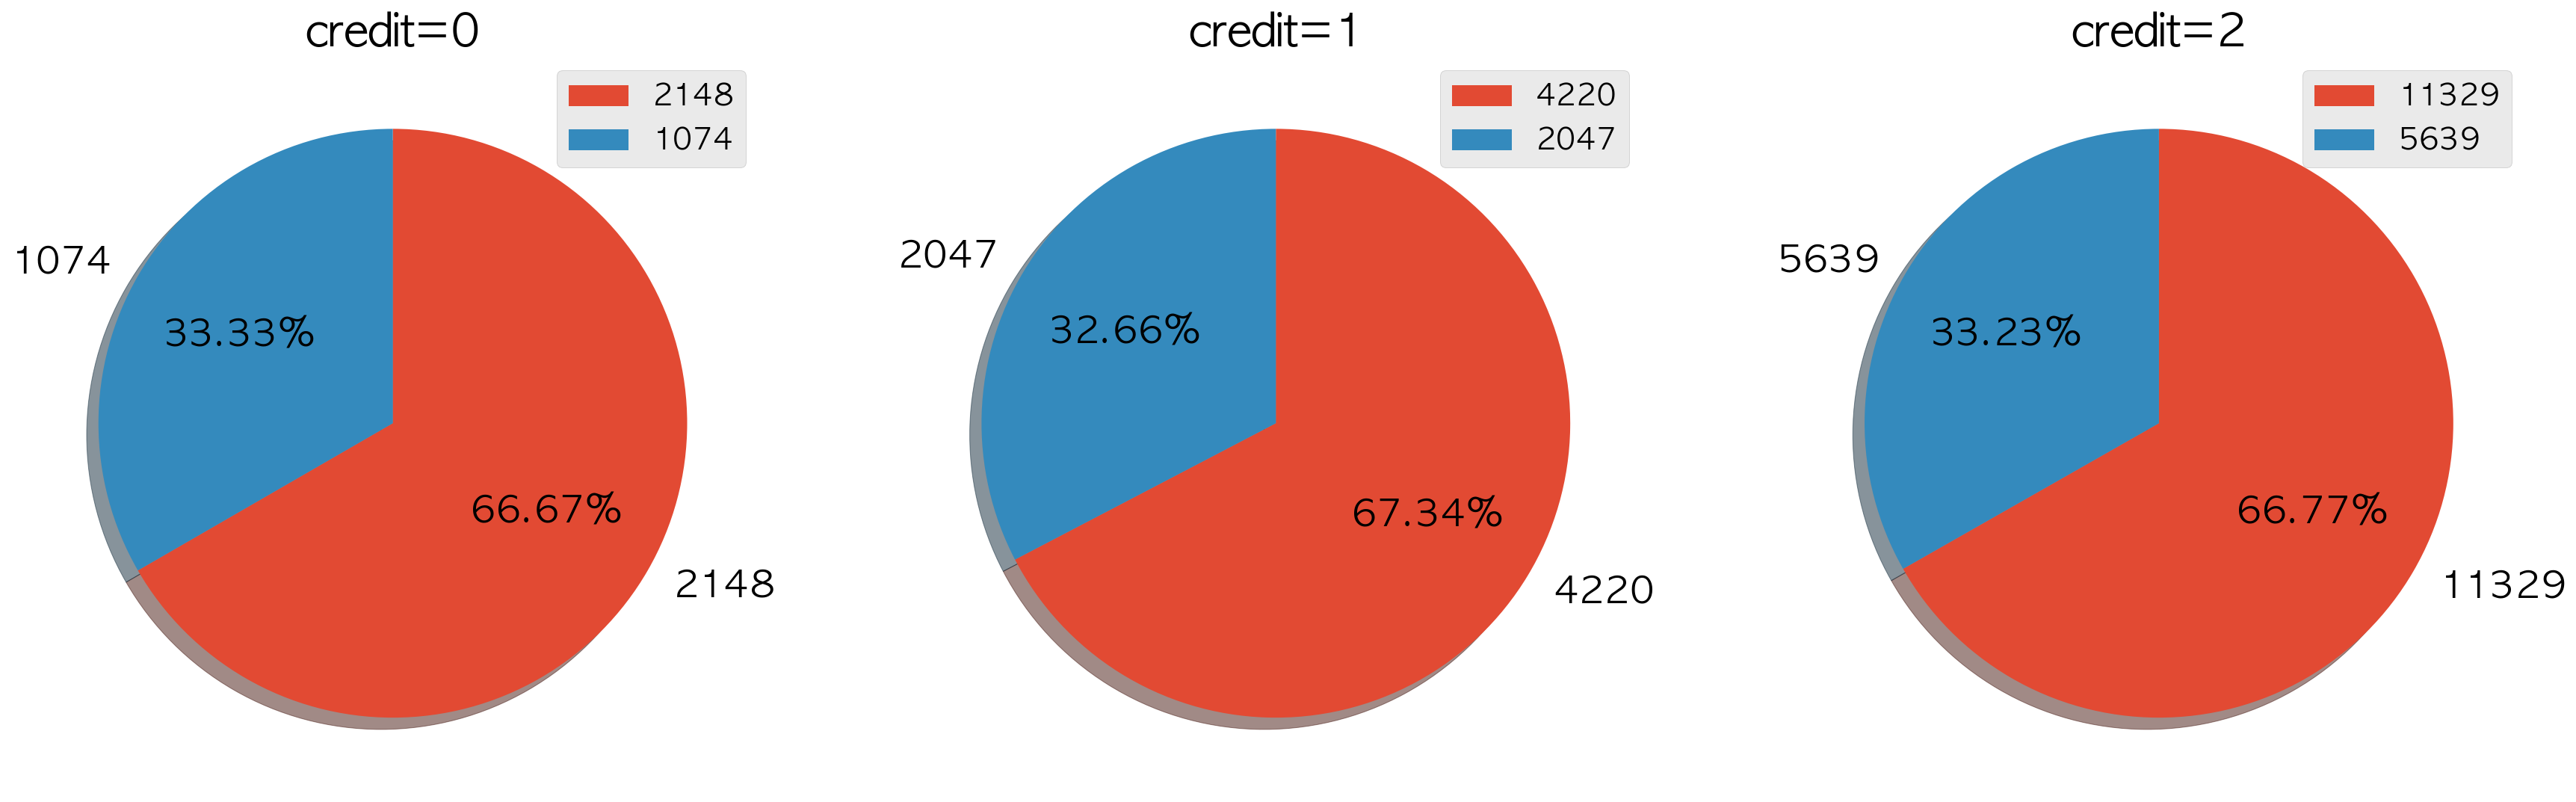

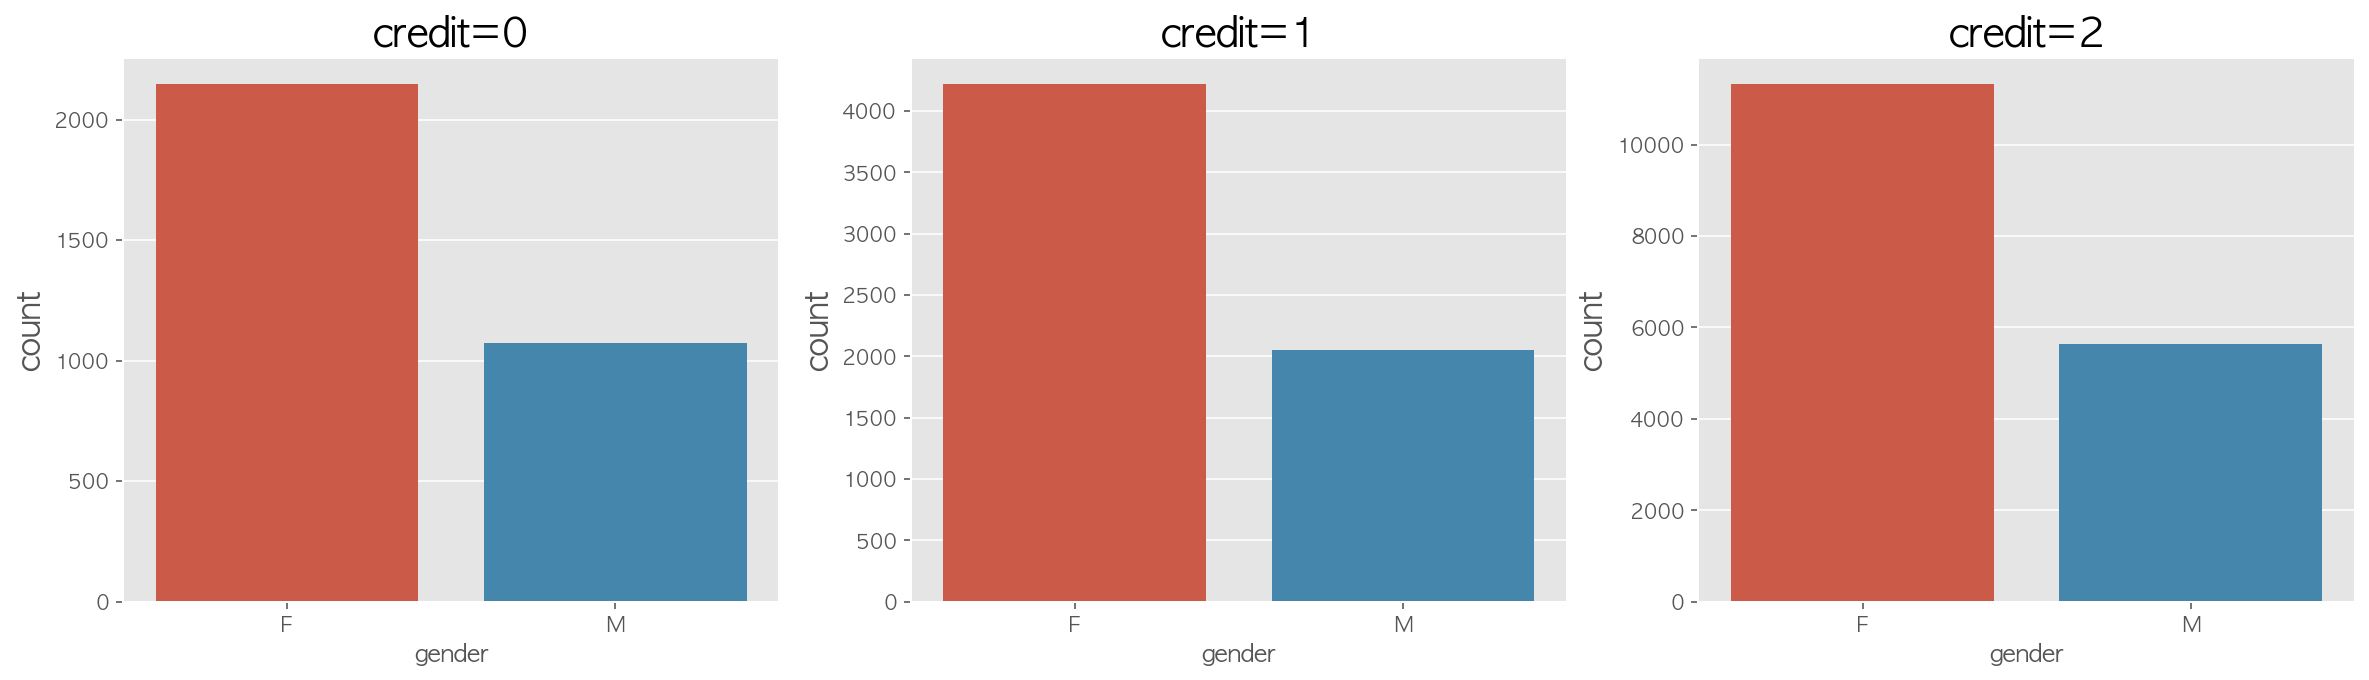

In [20]:
# 성별에 따른 신용등급 분포 확인
make_plot('gender')

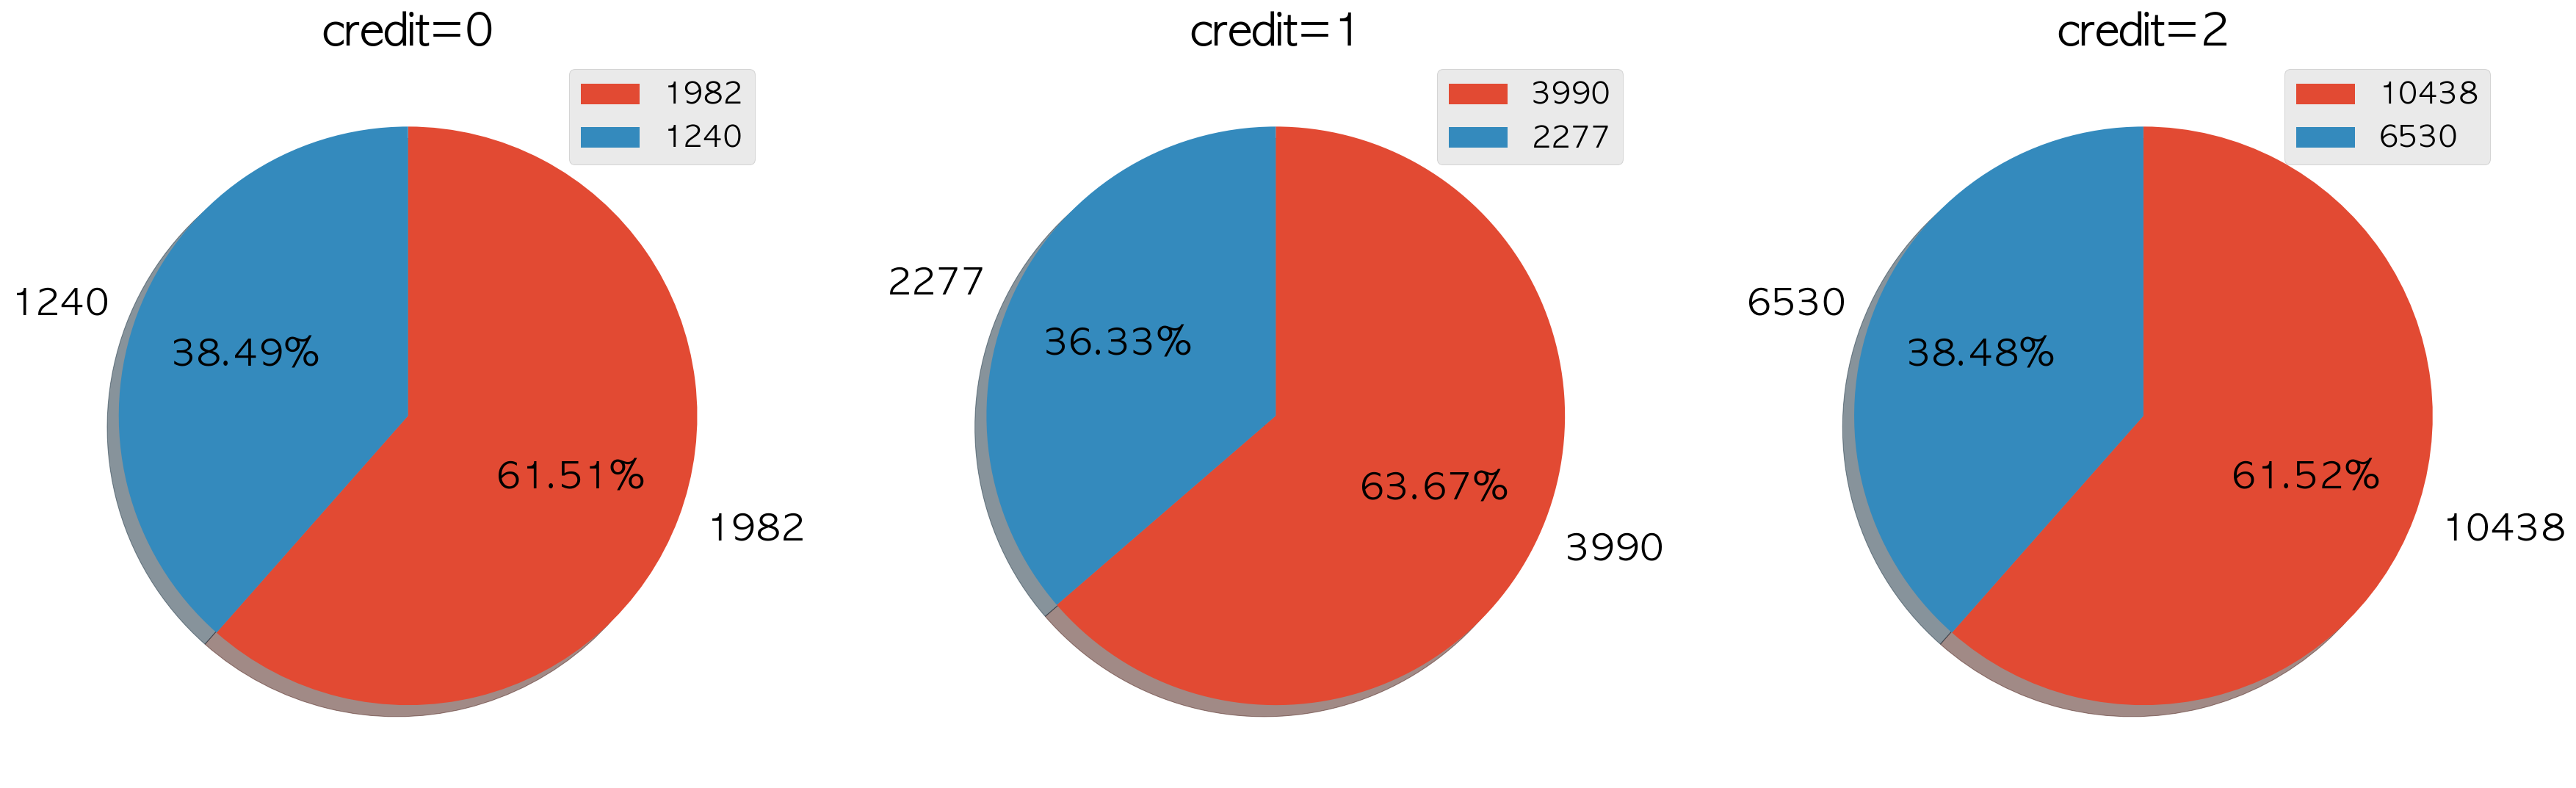

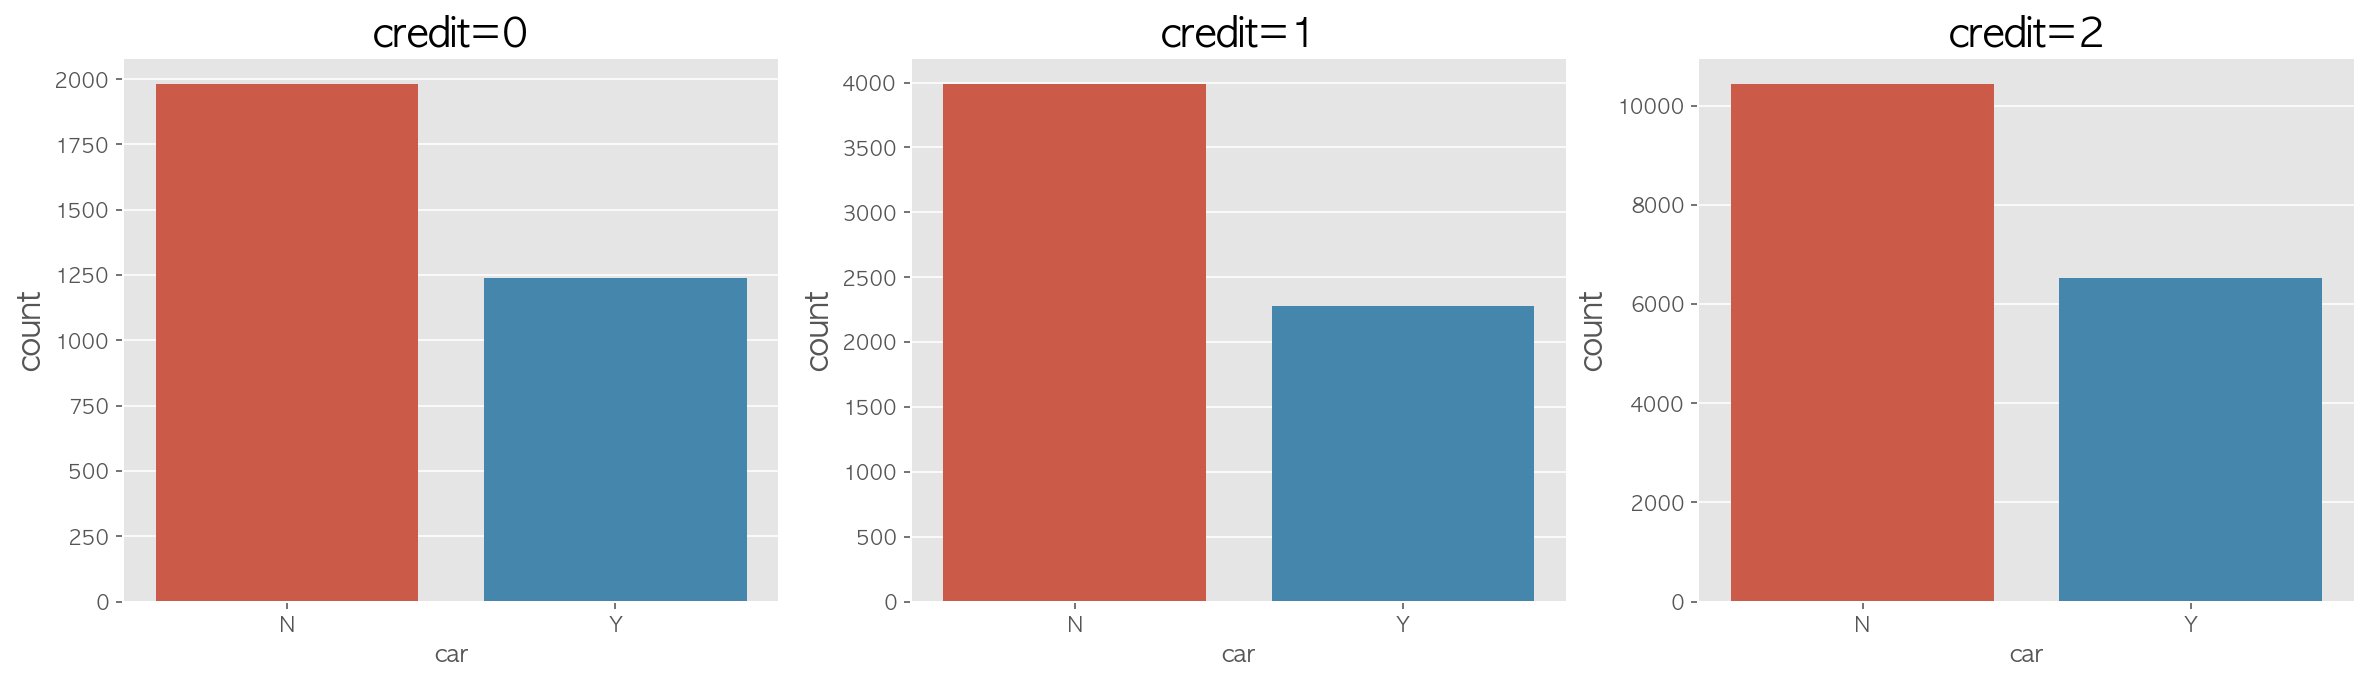

In [21]:
make_plot('car')

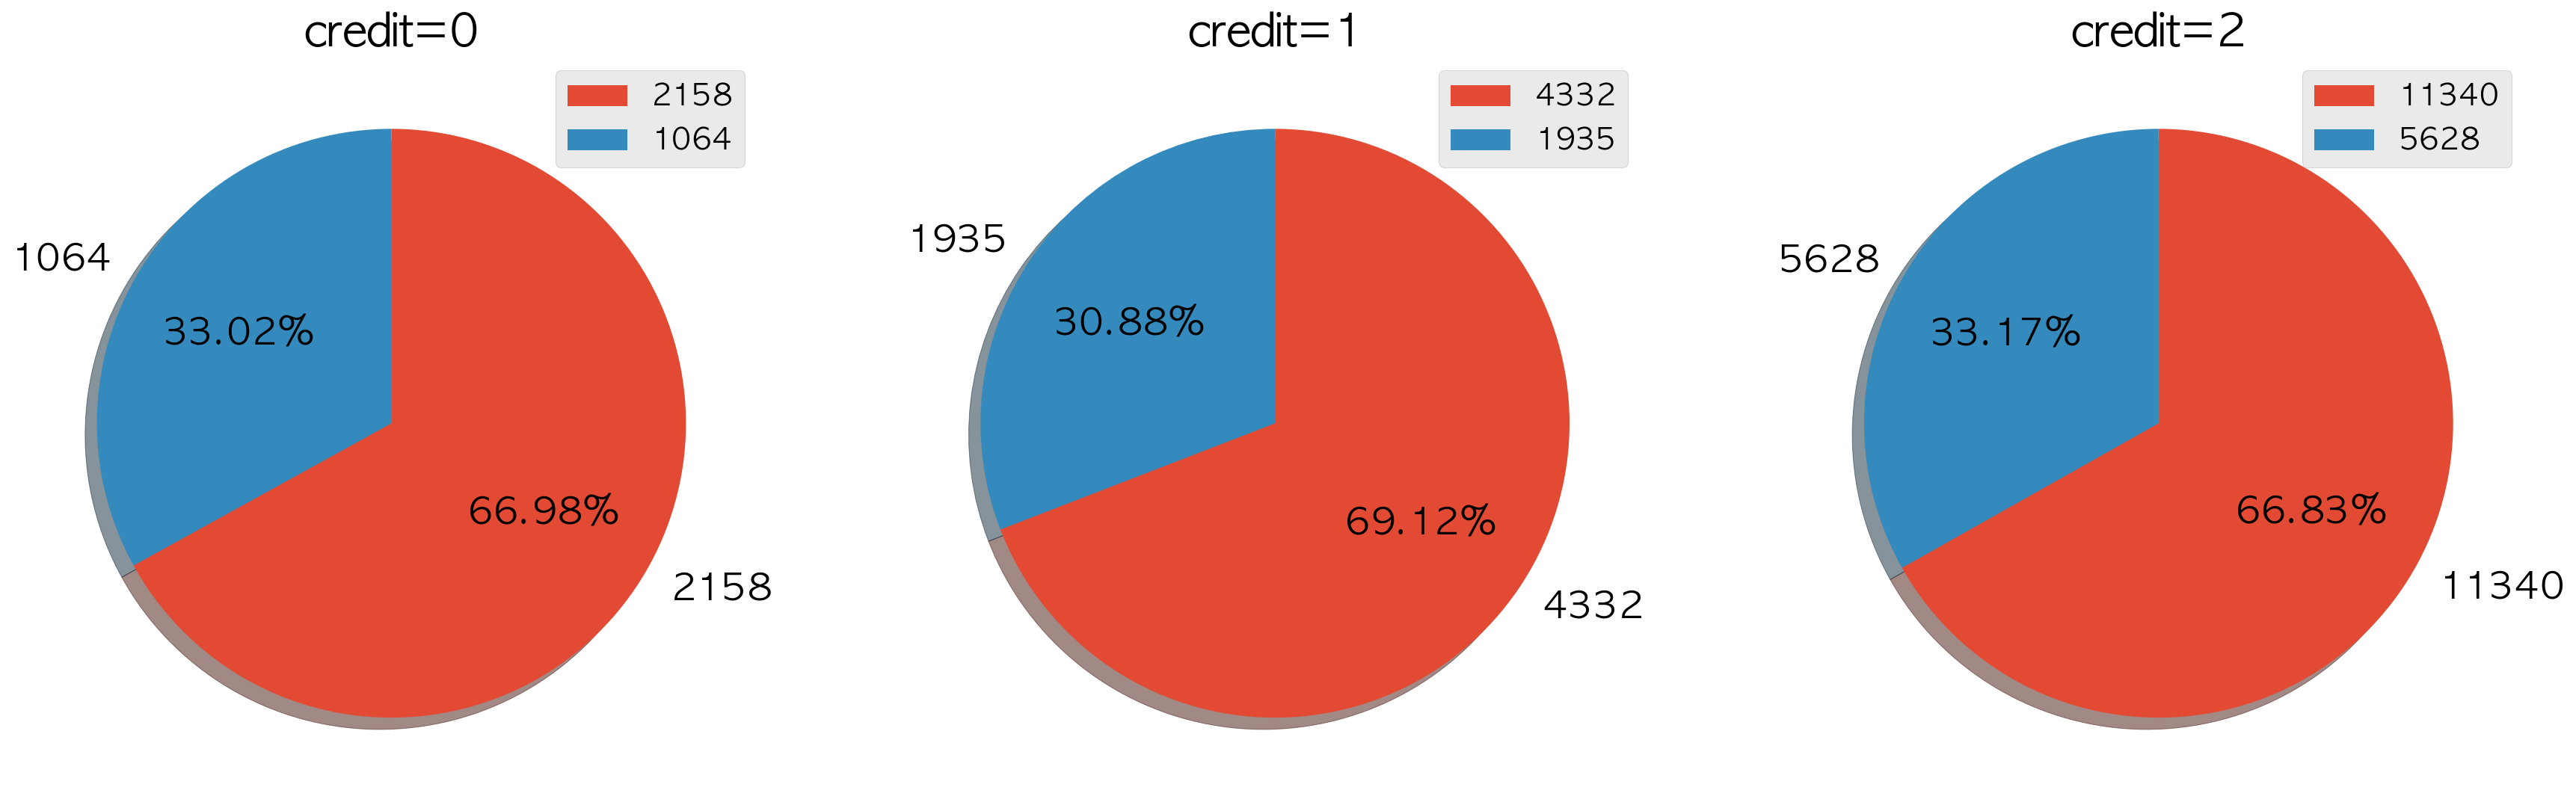

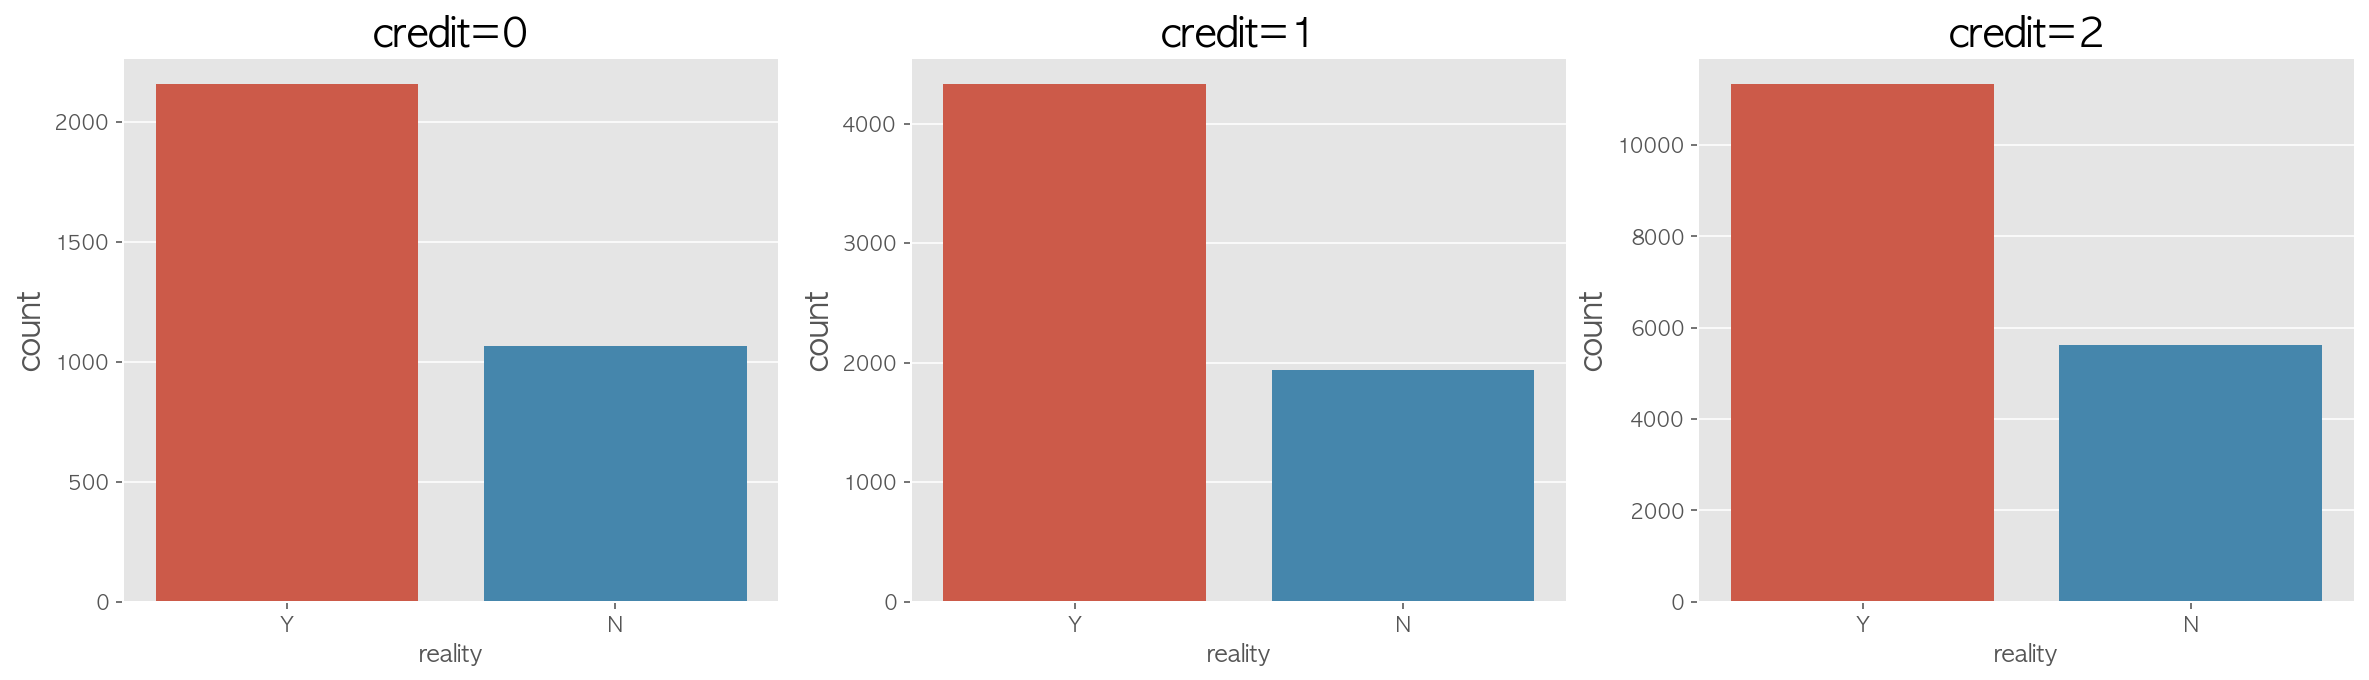

In [22]:
make_plot('reality')

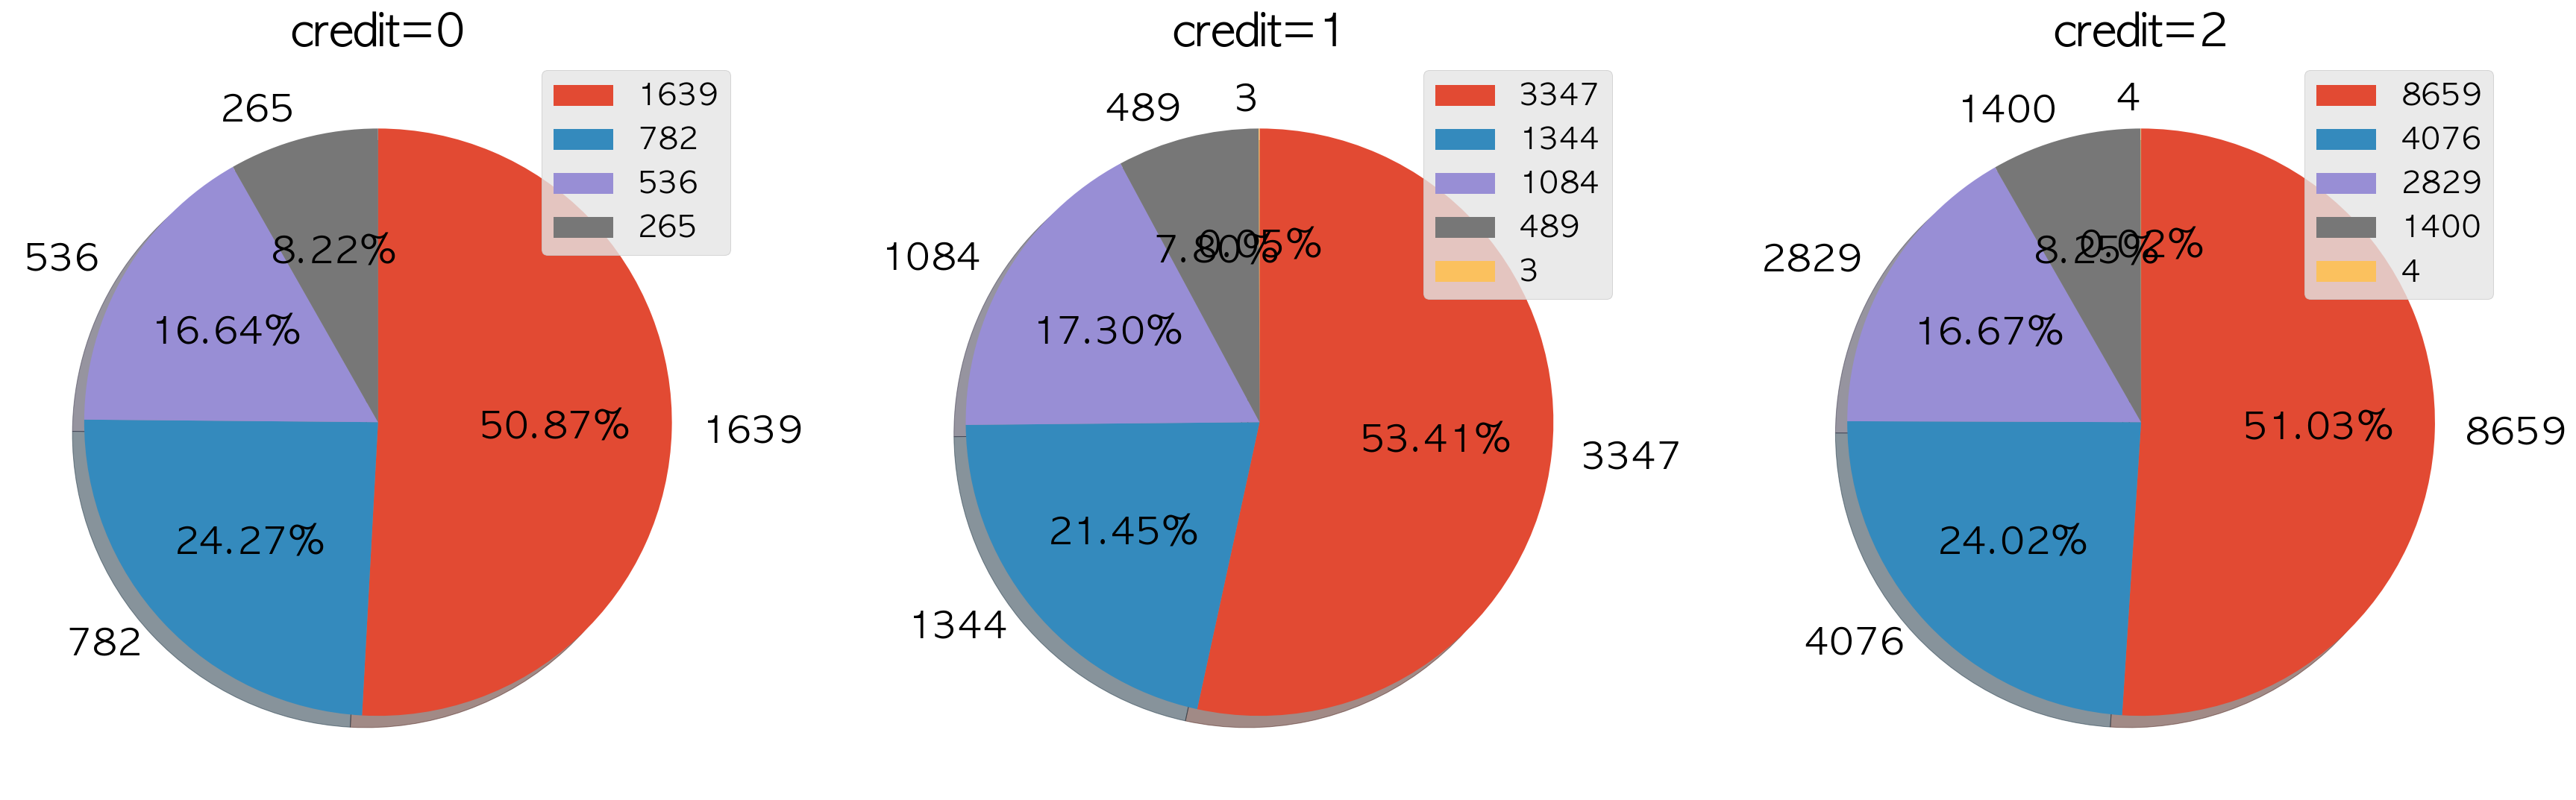

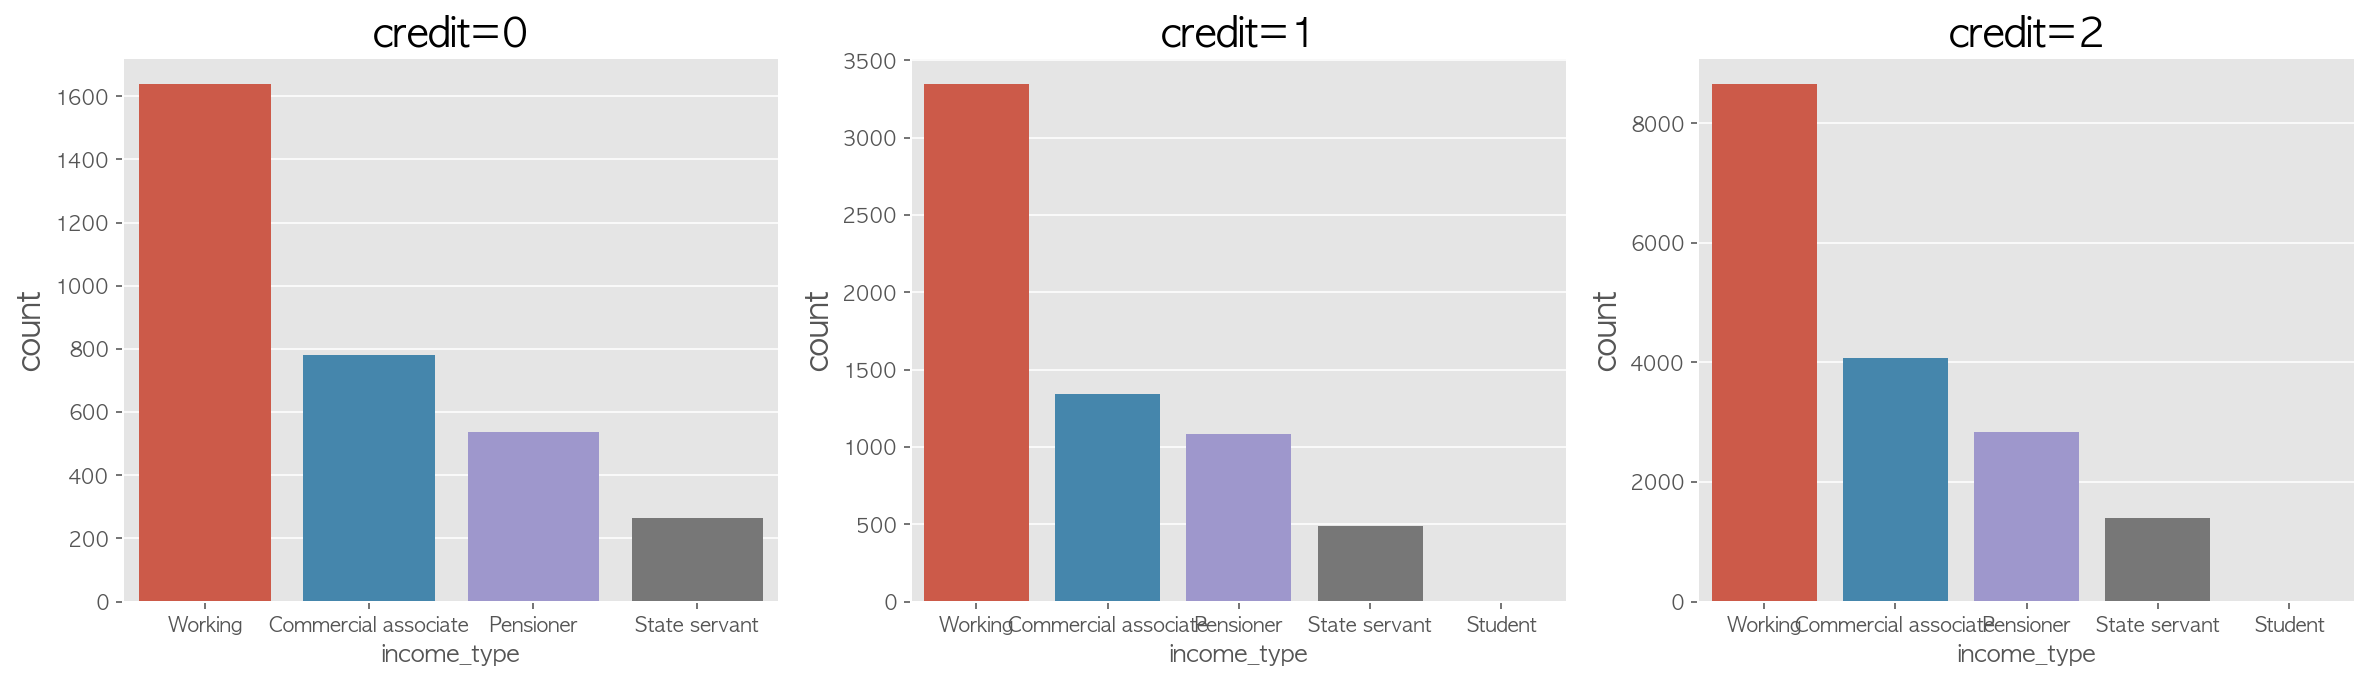

In [23]:
make_plot('income_type')

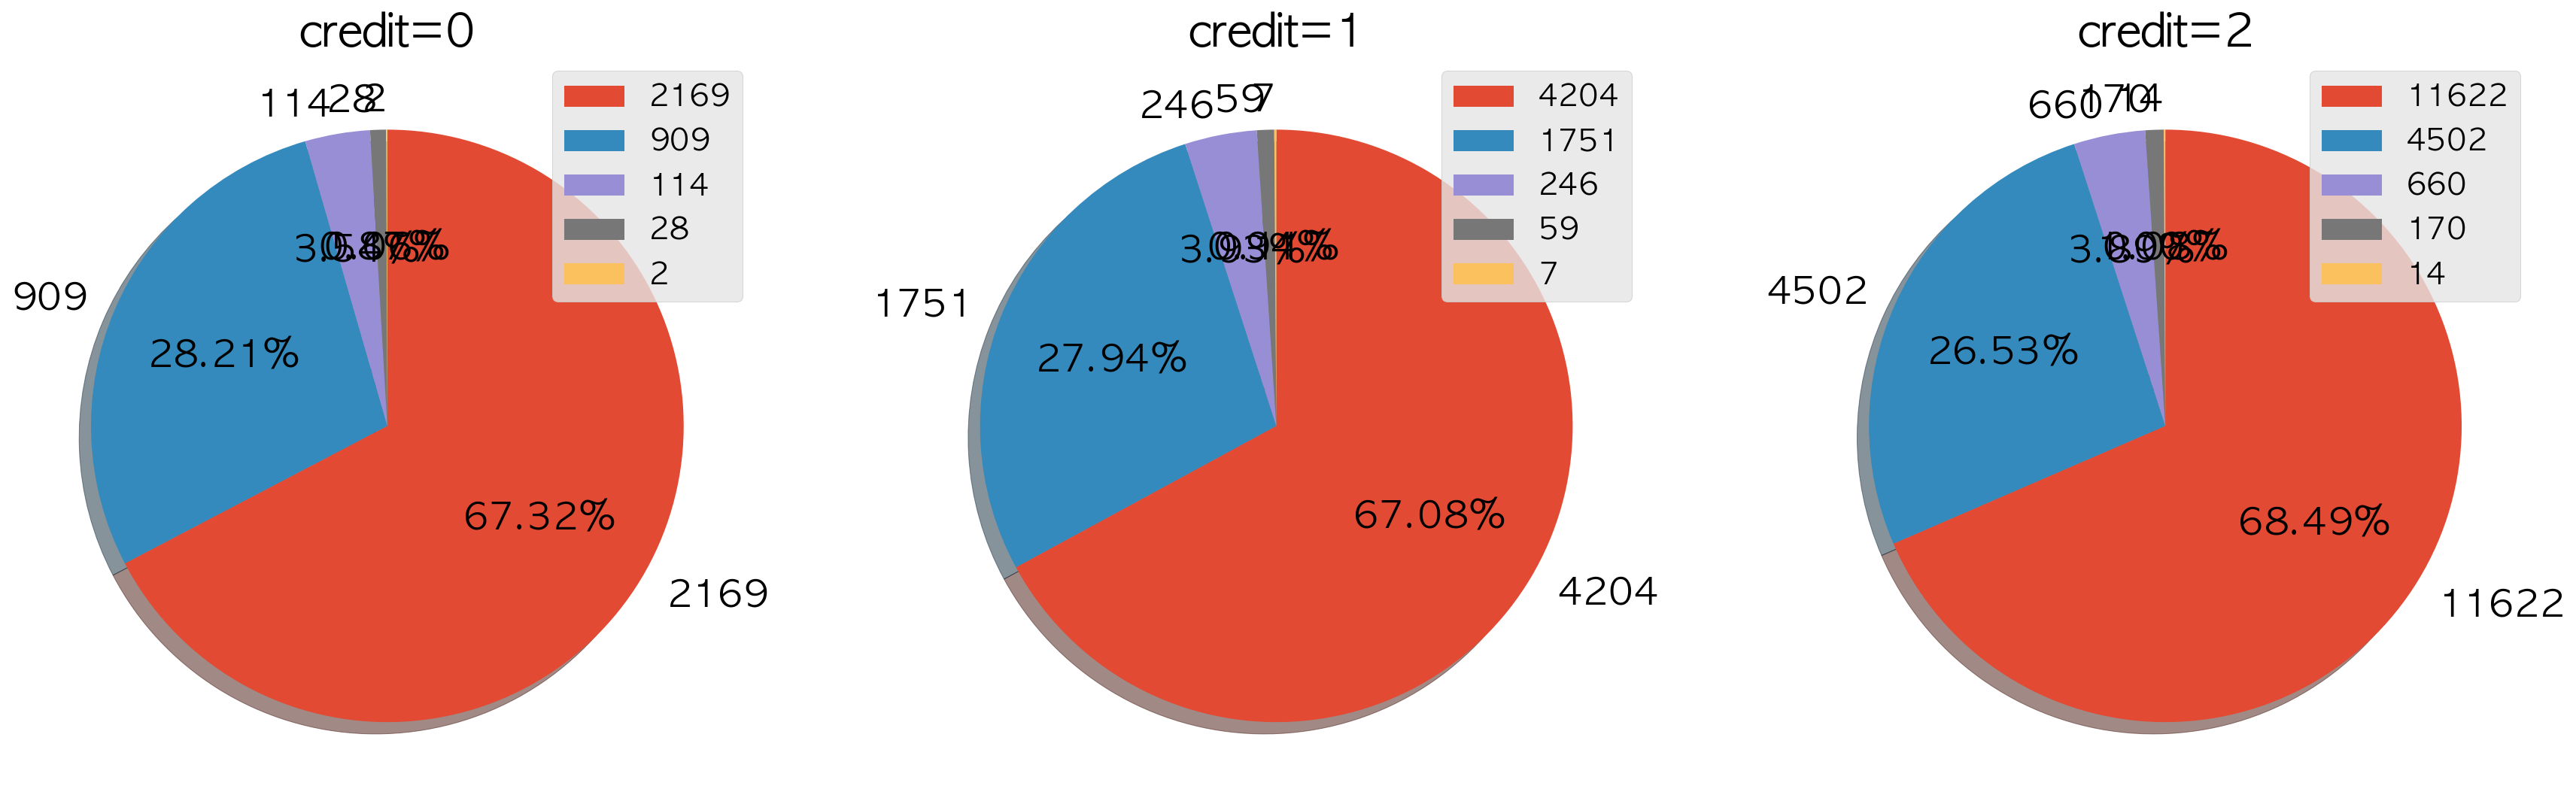

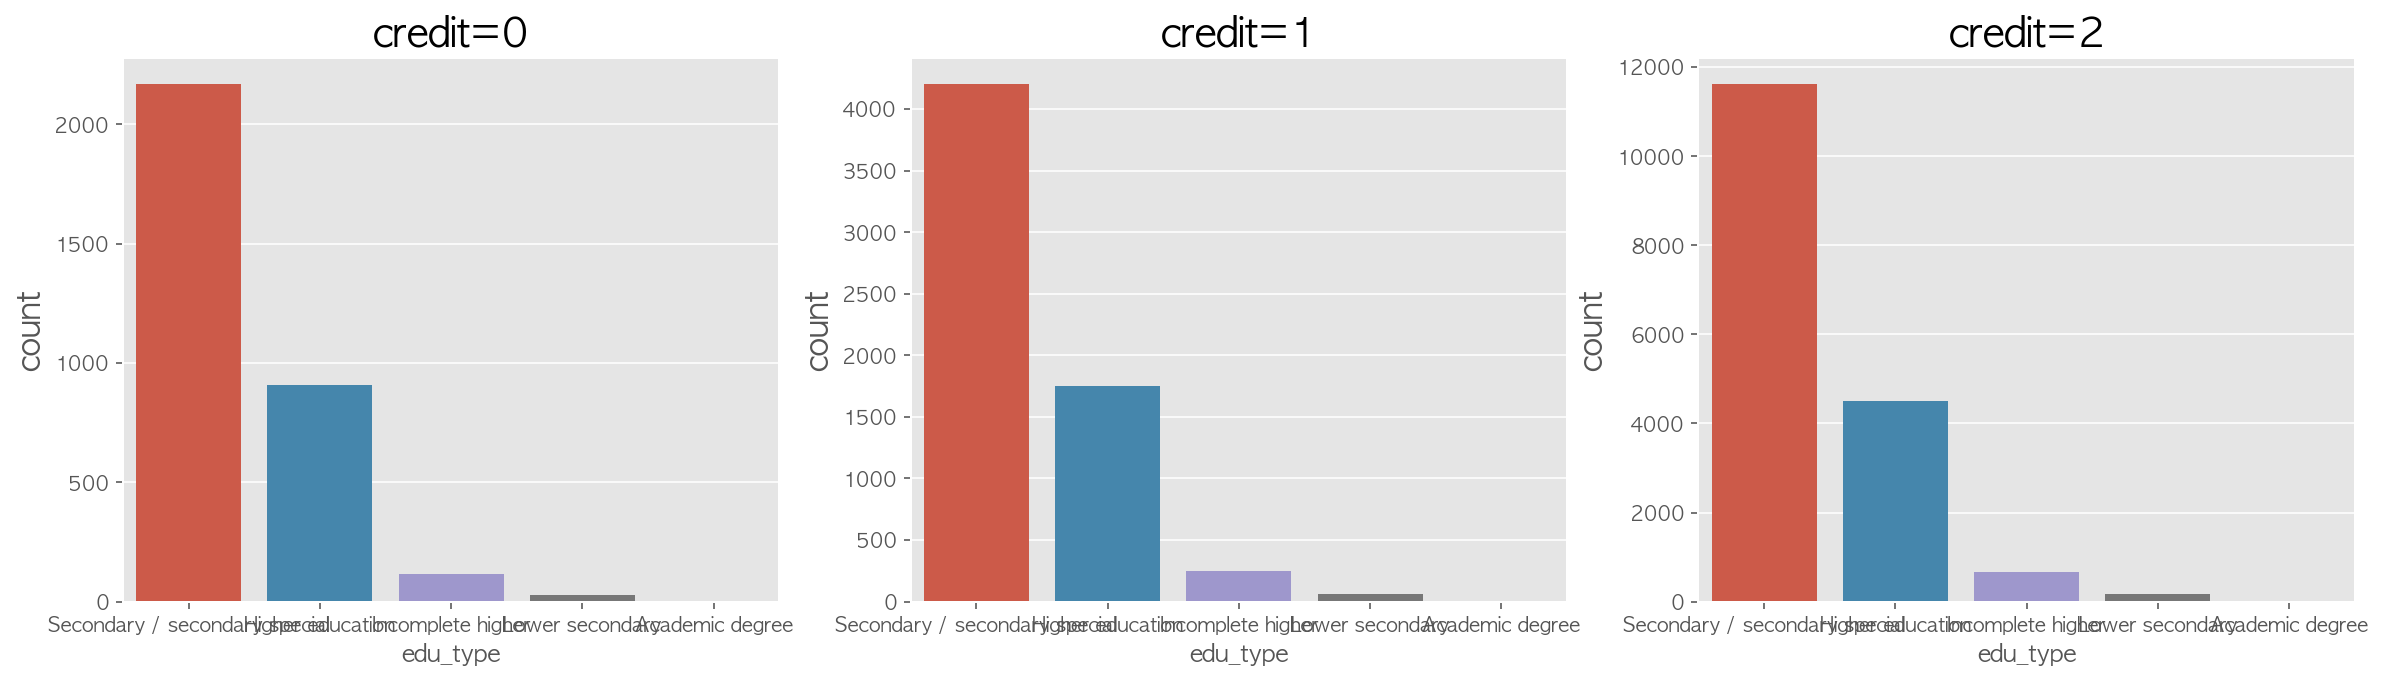

In [24]:
make_plot('edu_type')

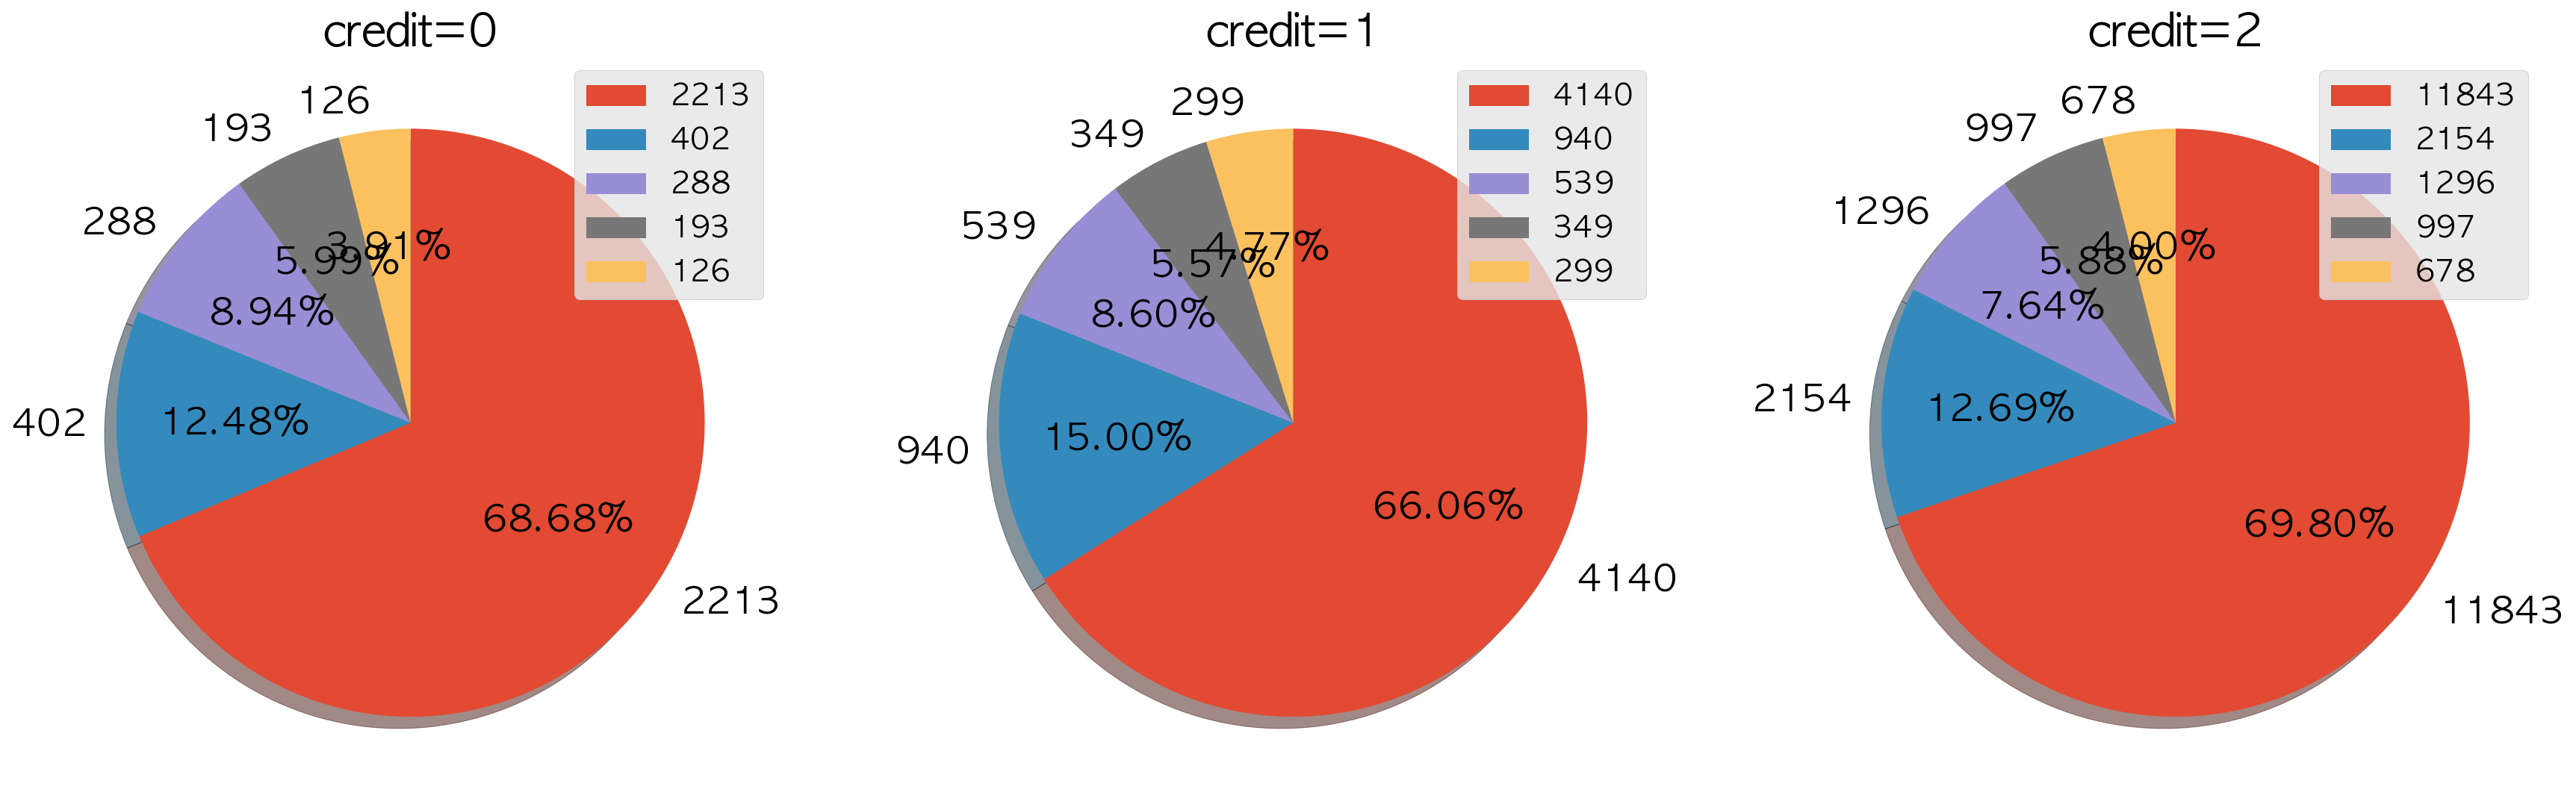

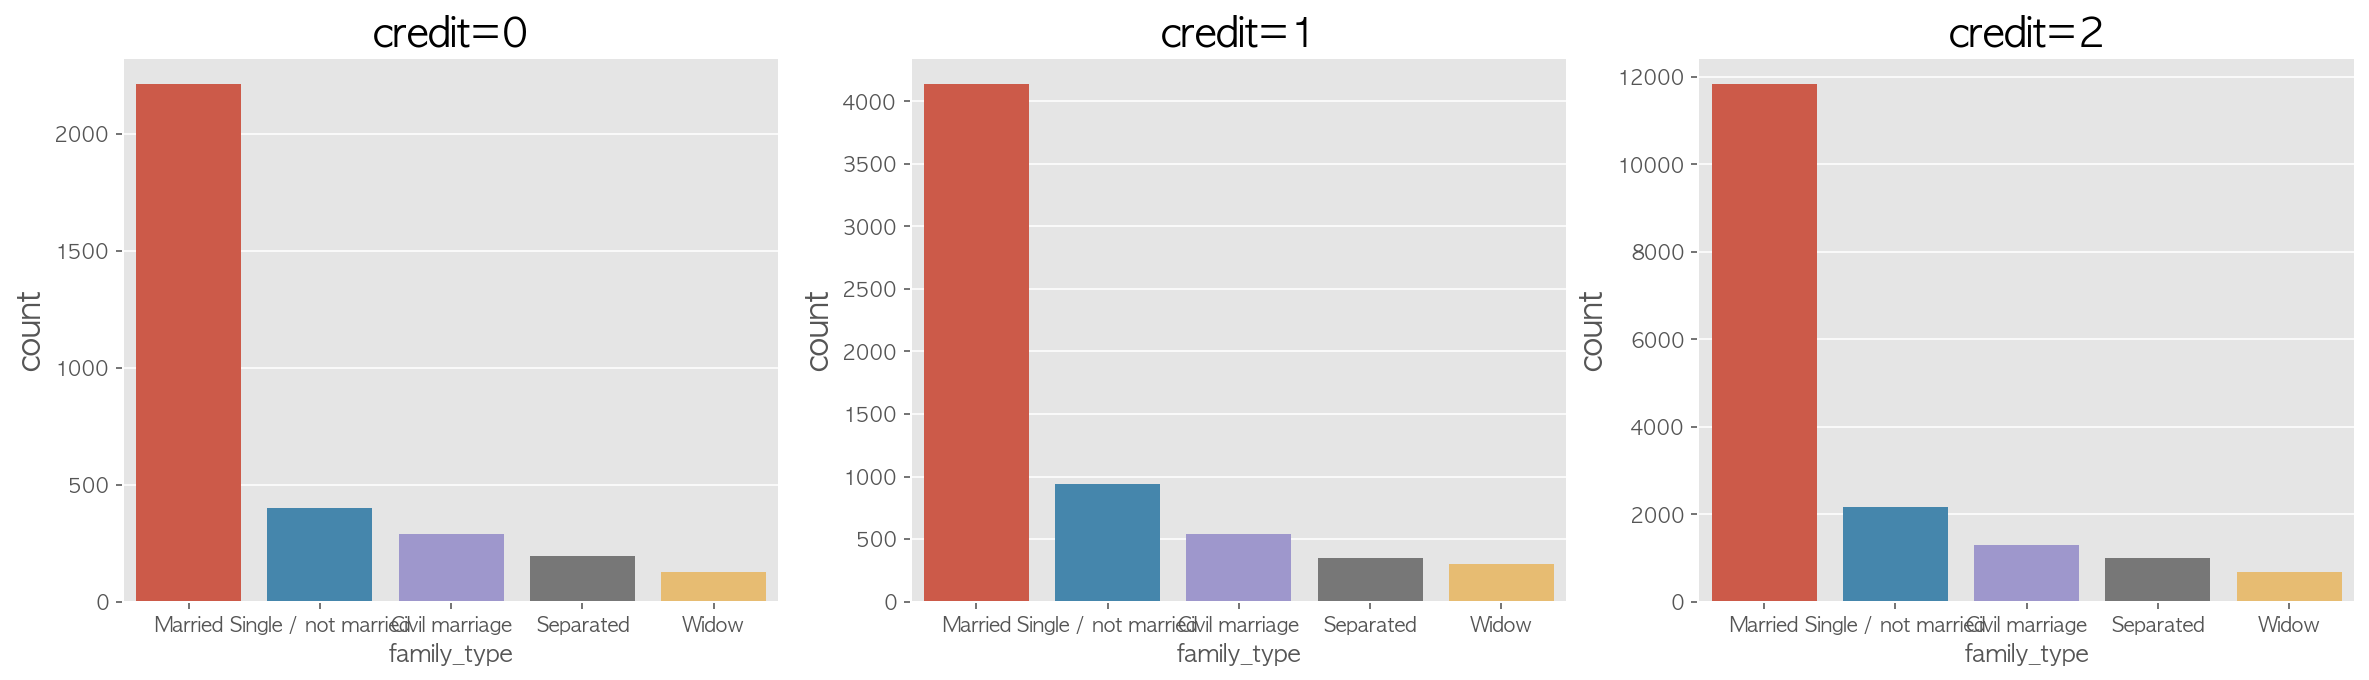

In [25]:
make_plot('family_type')

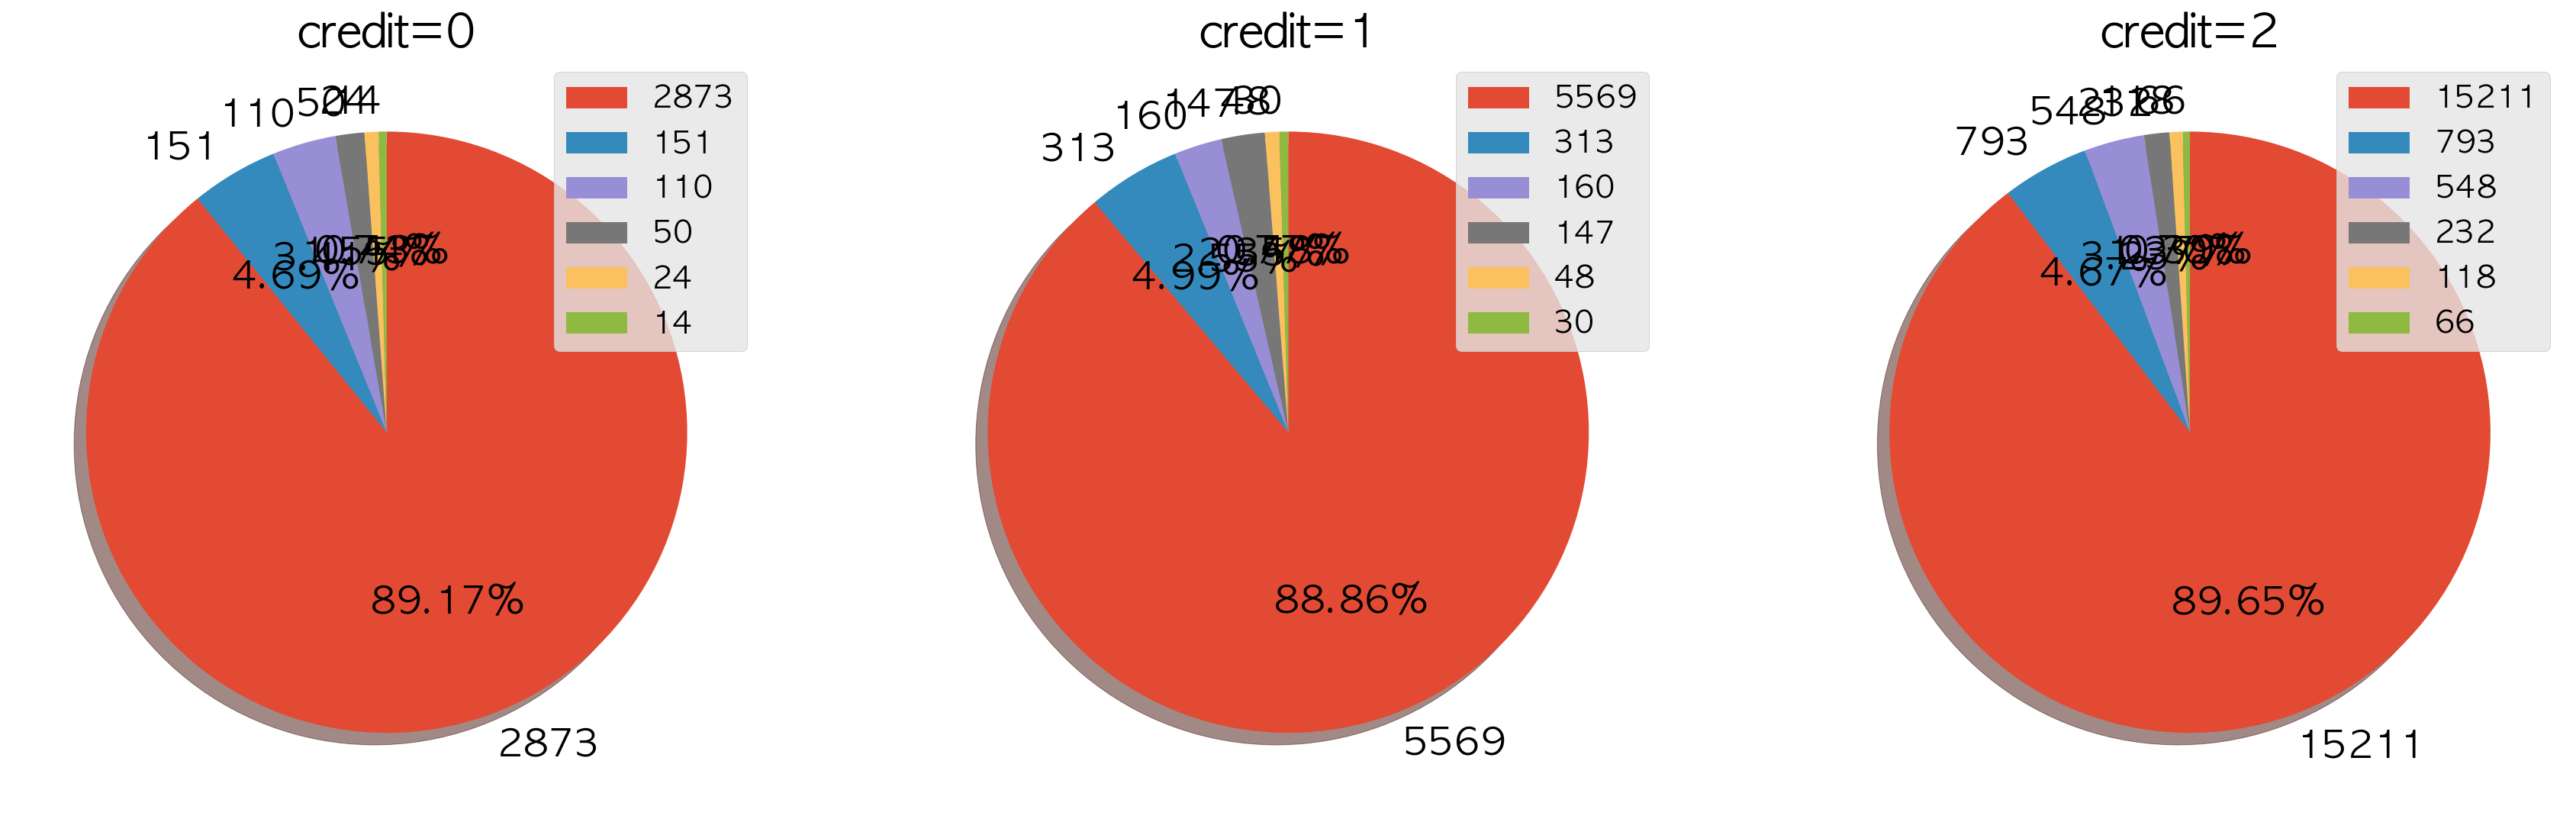

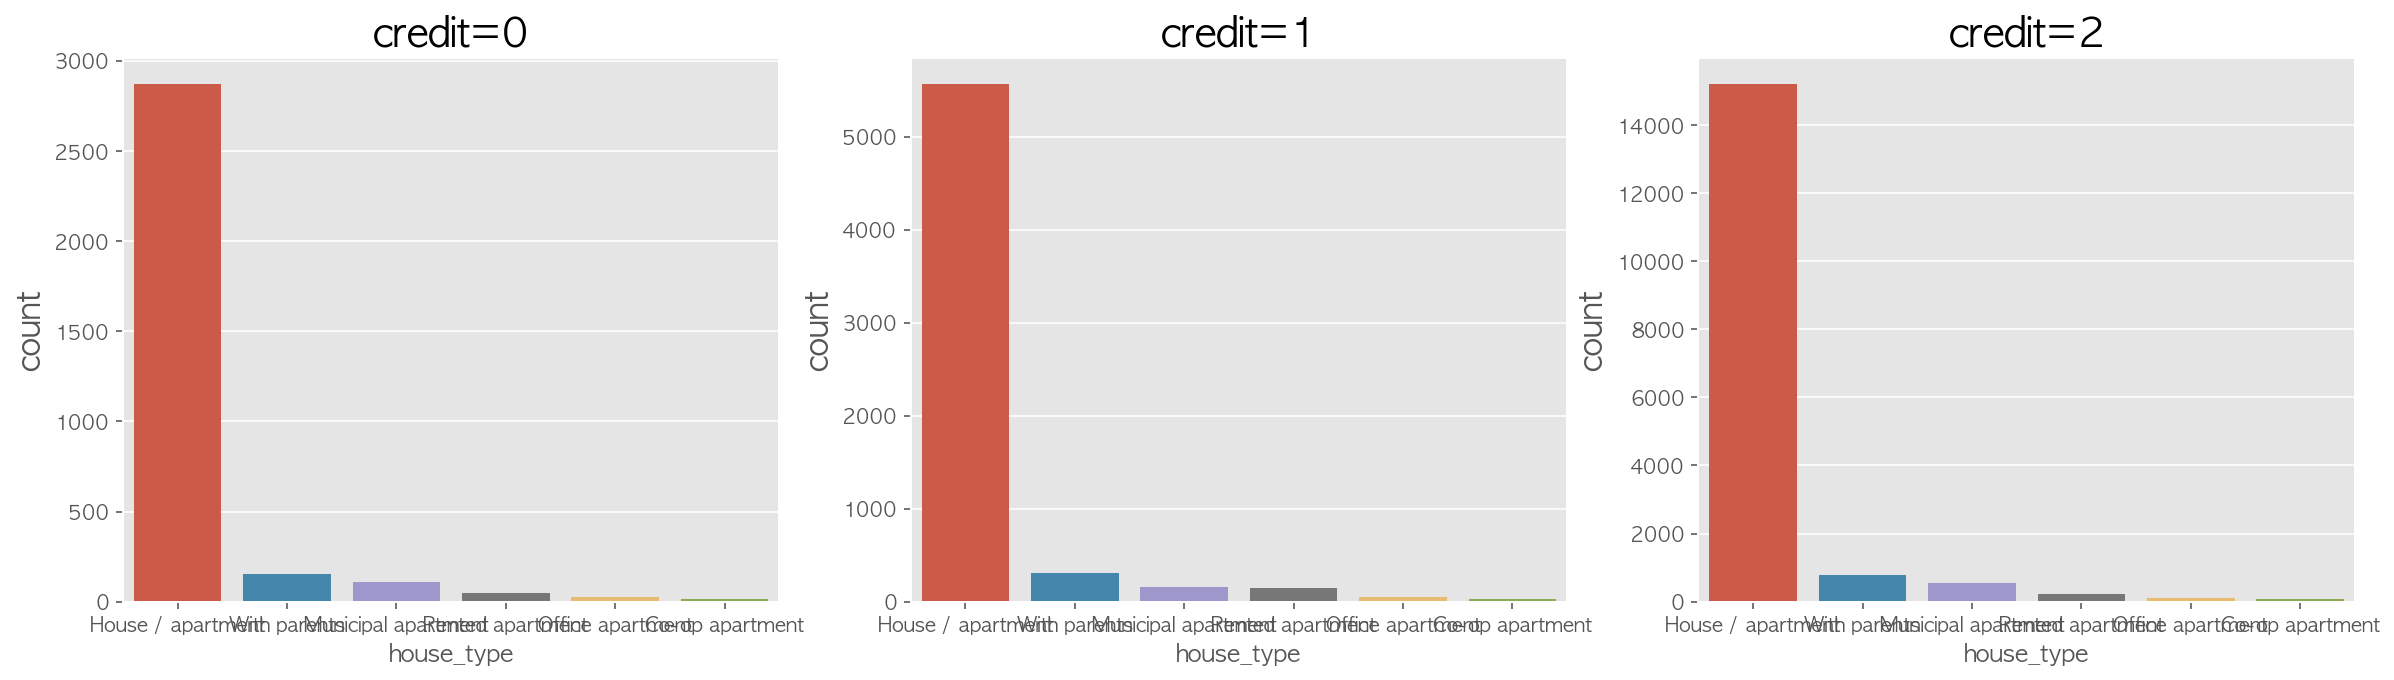

In [26]:
make_plot('house_type')

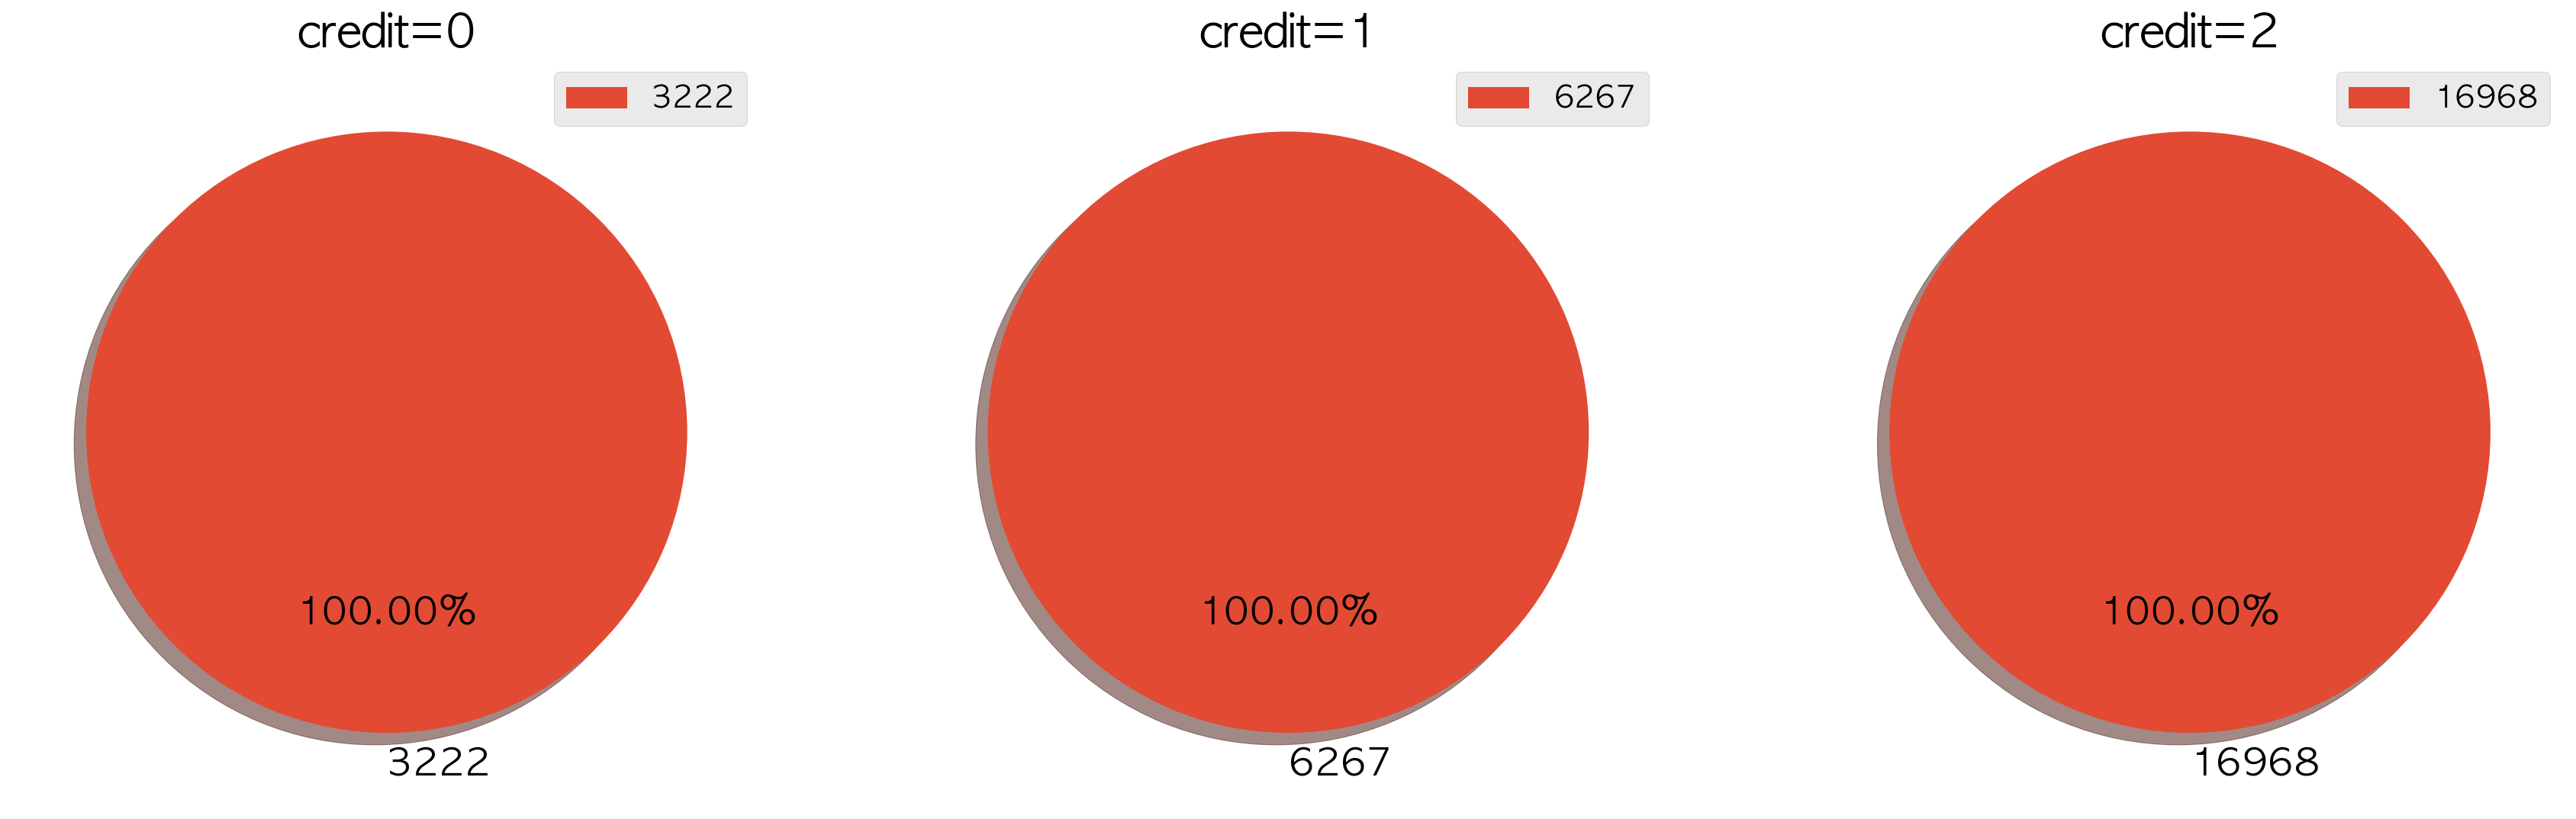

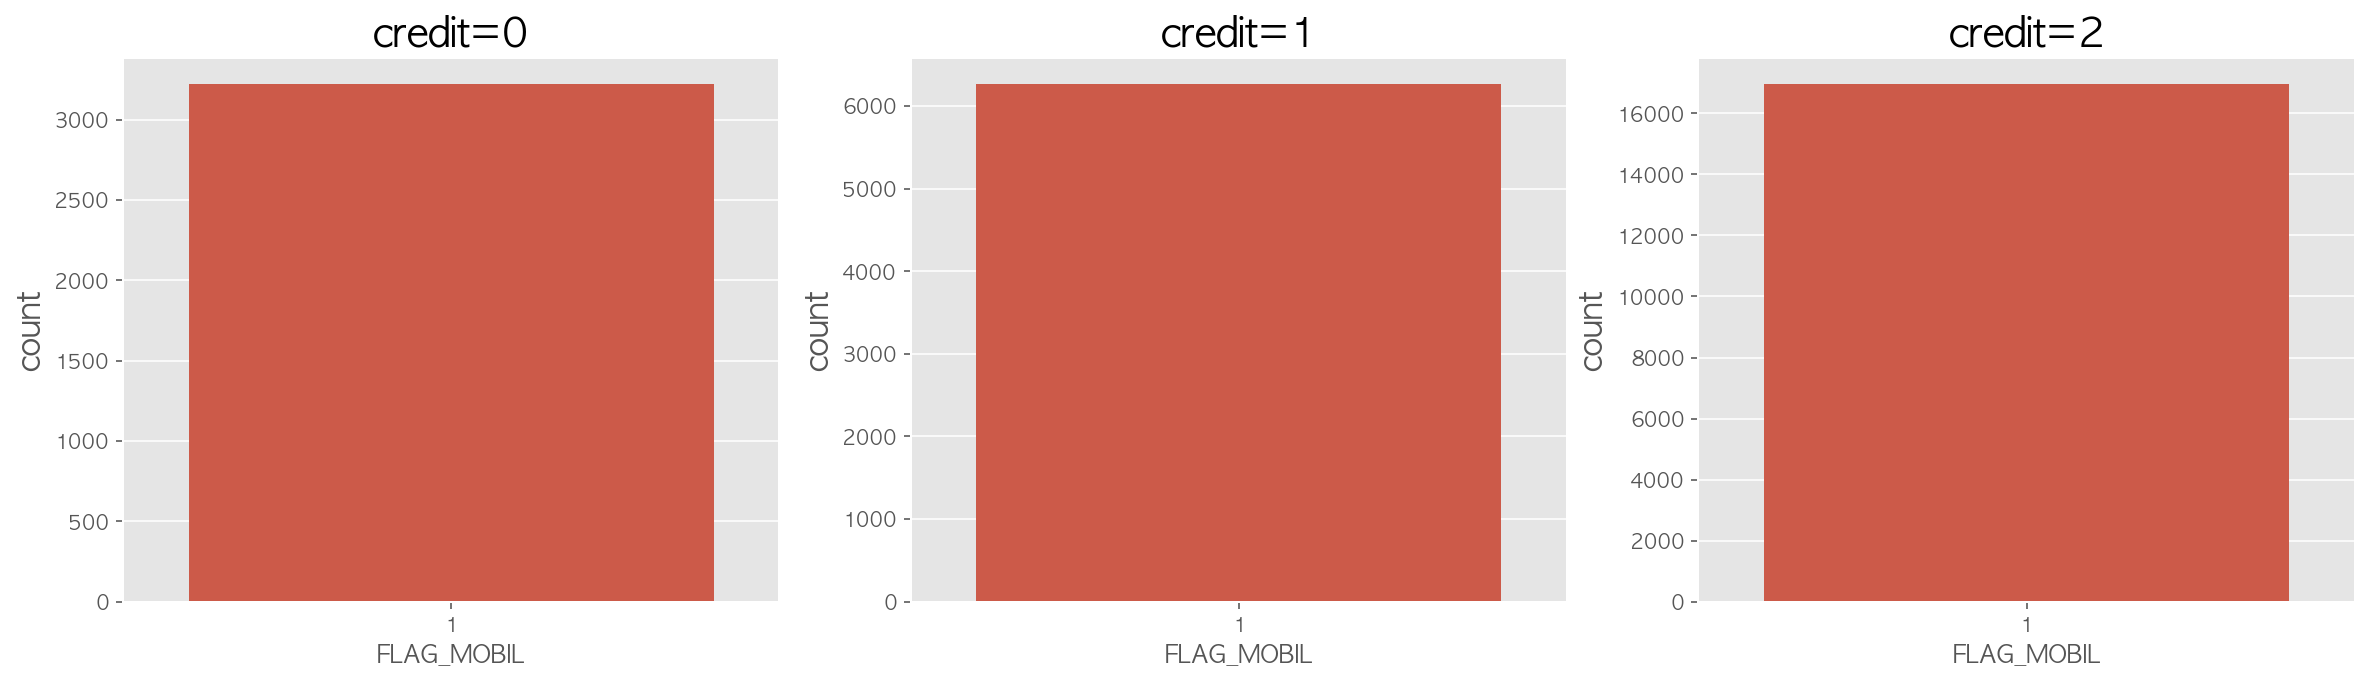

In [27]:
make_plot('FLAG_MOBIL')

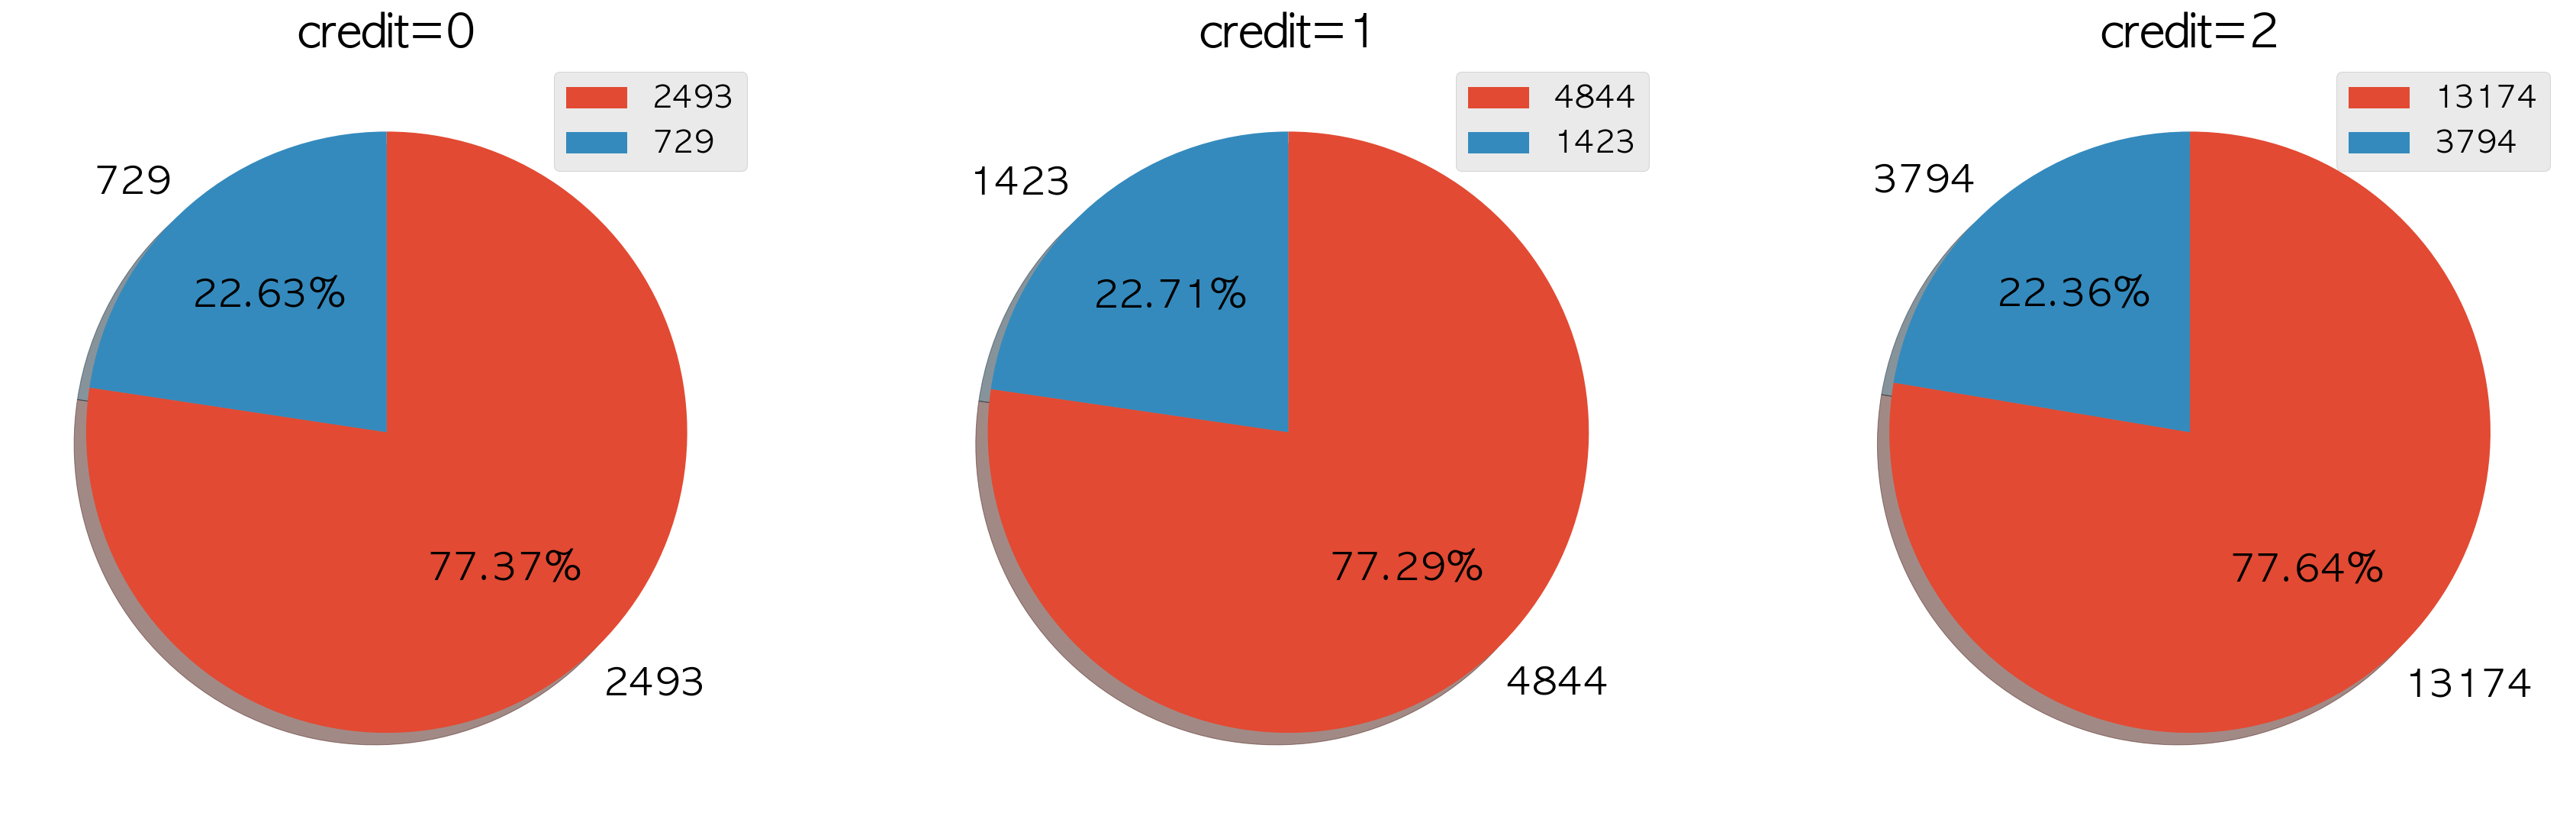

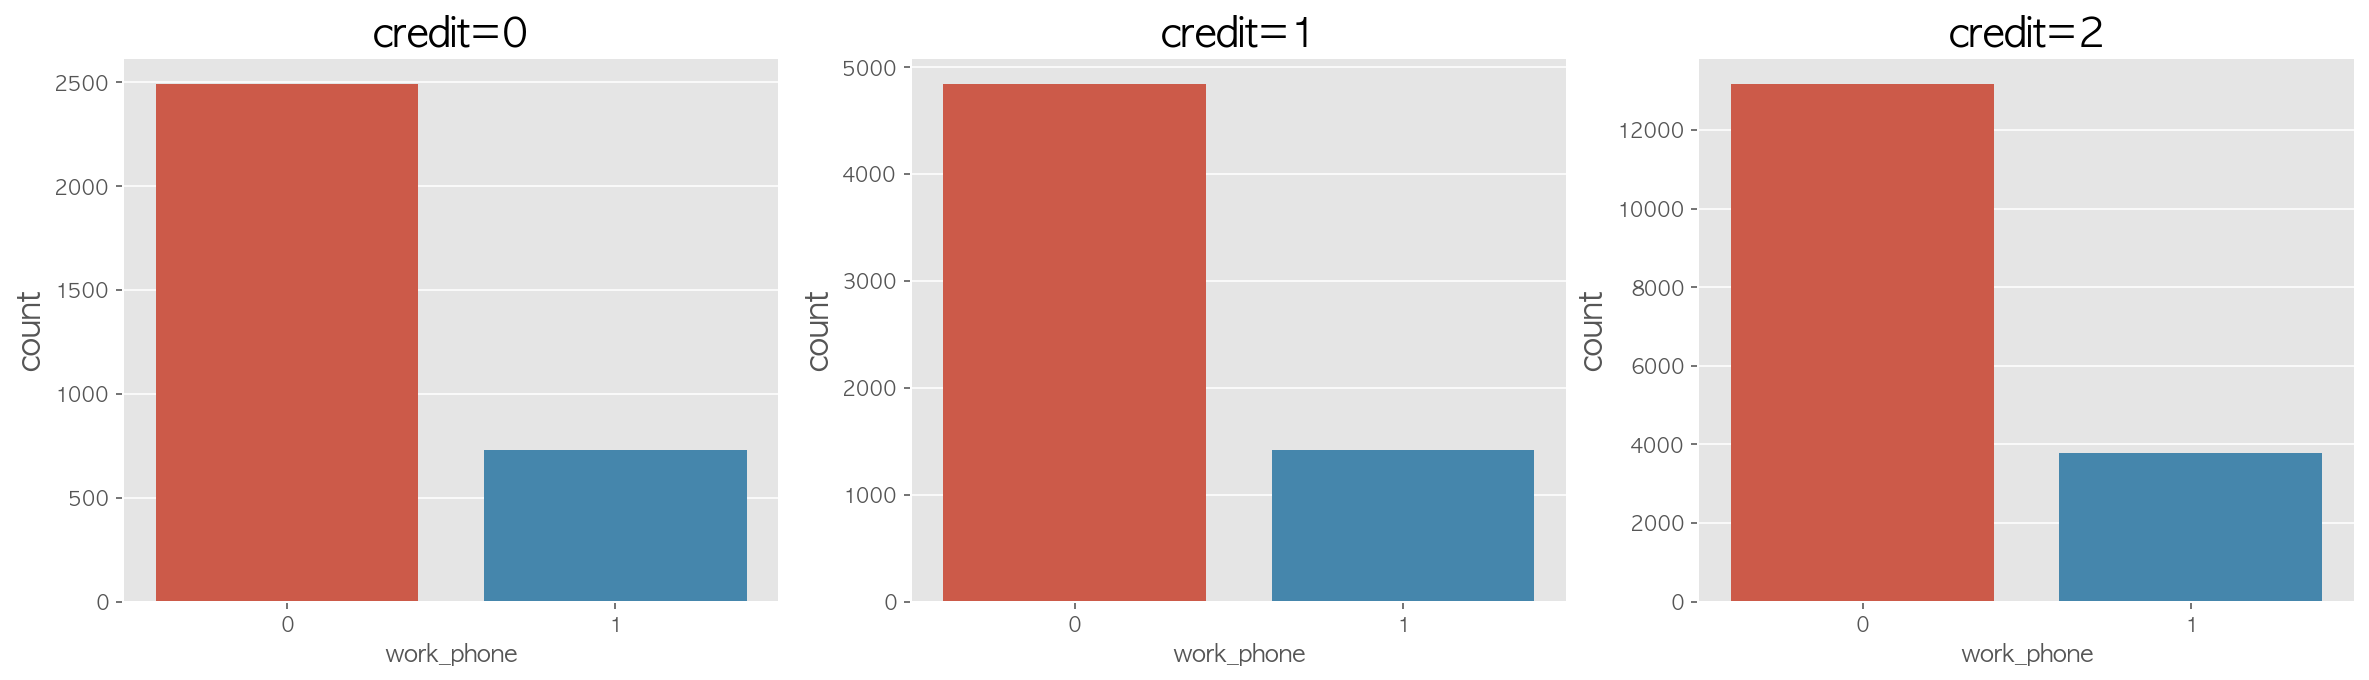

In [28]:
make_plot('work_phone')

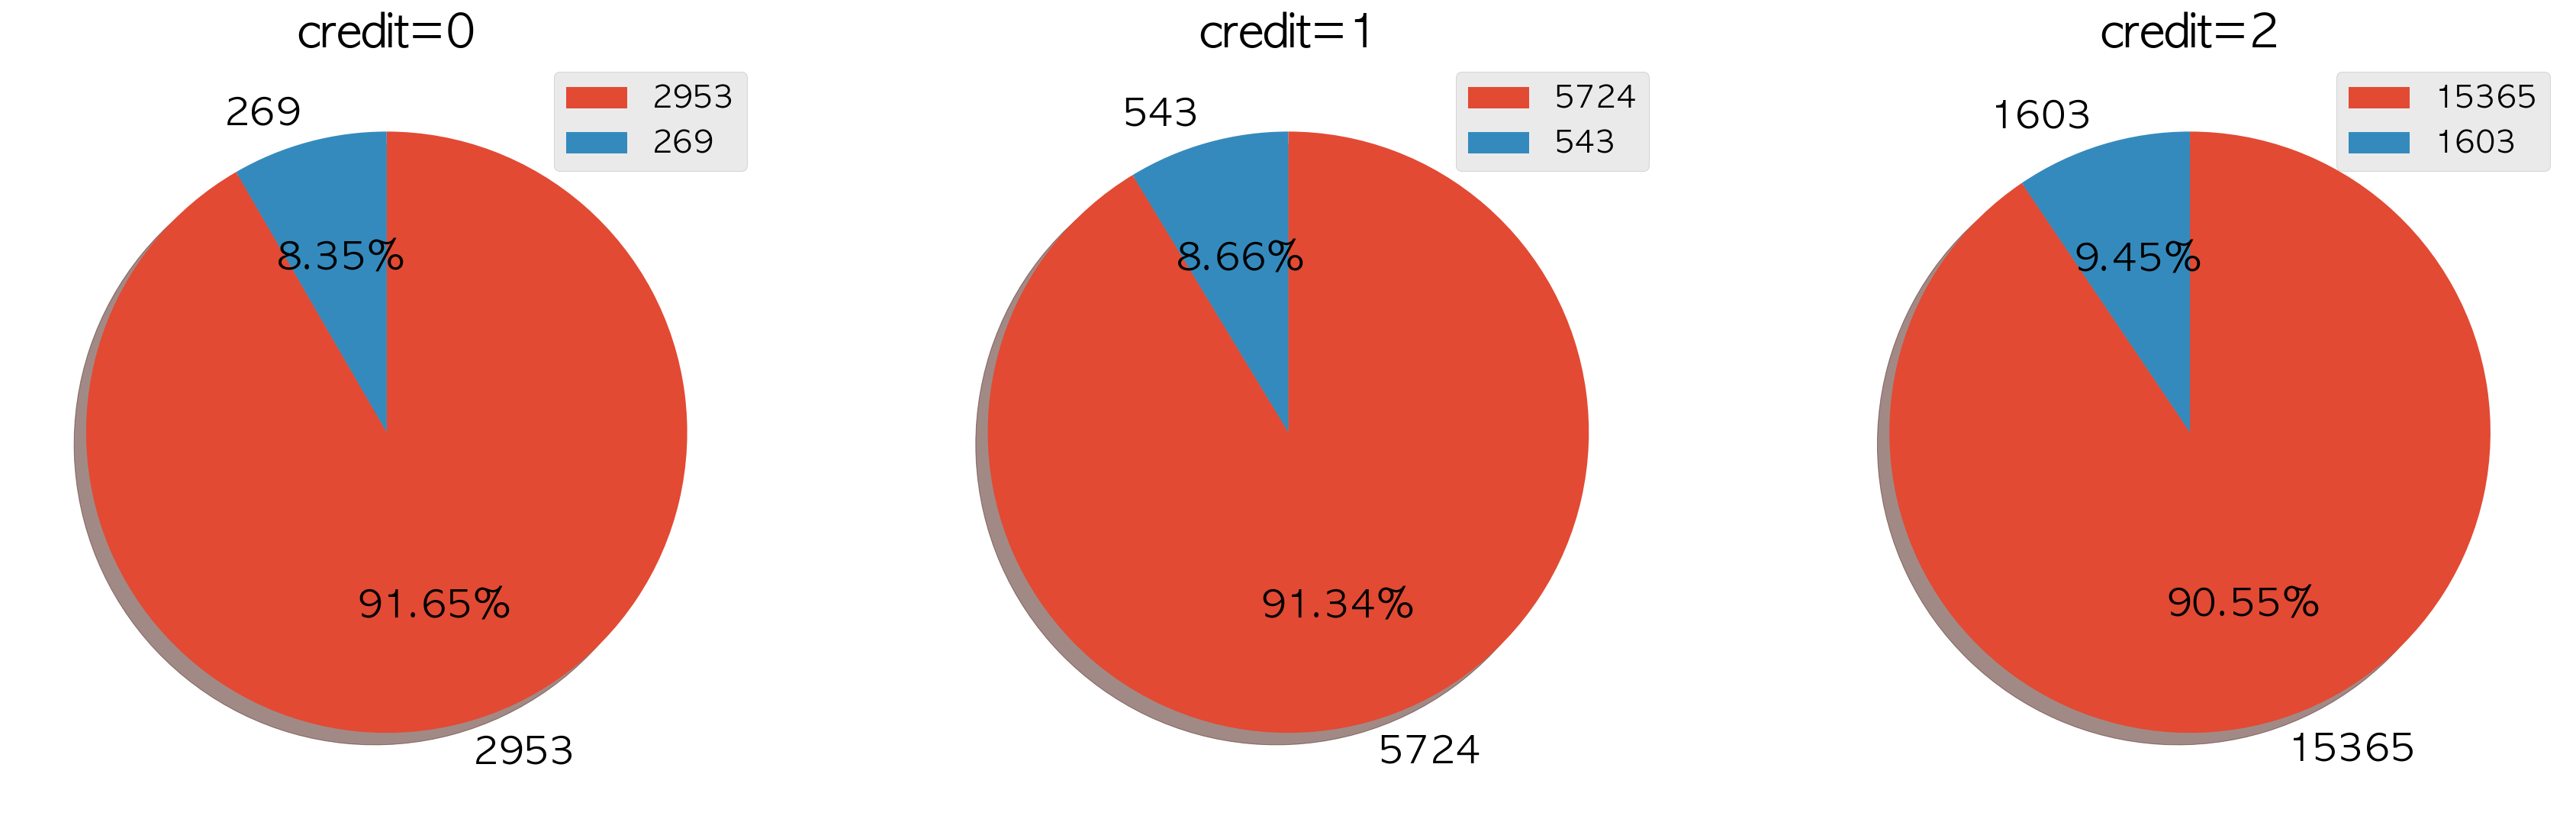

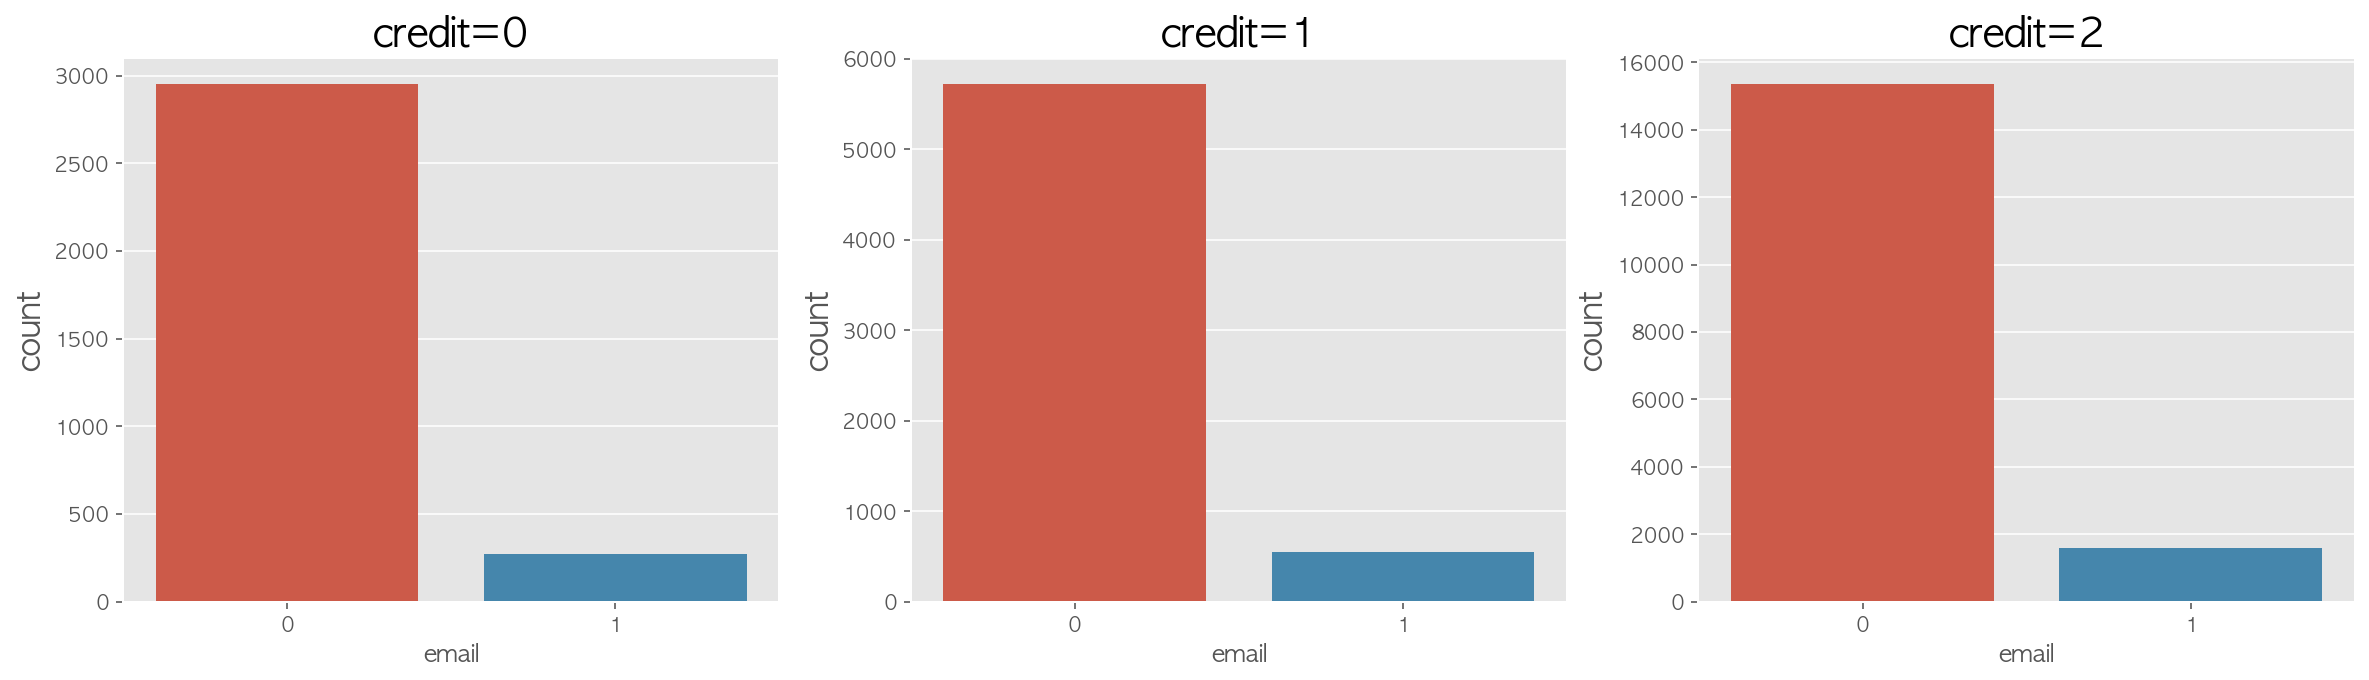

In [29]:
make_plot('email')

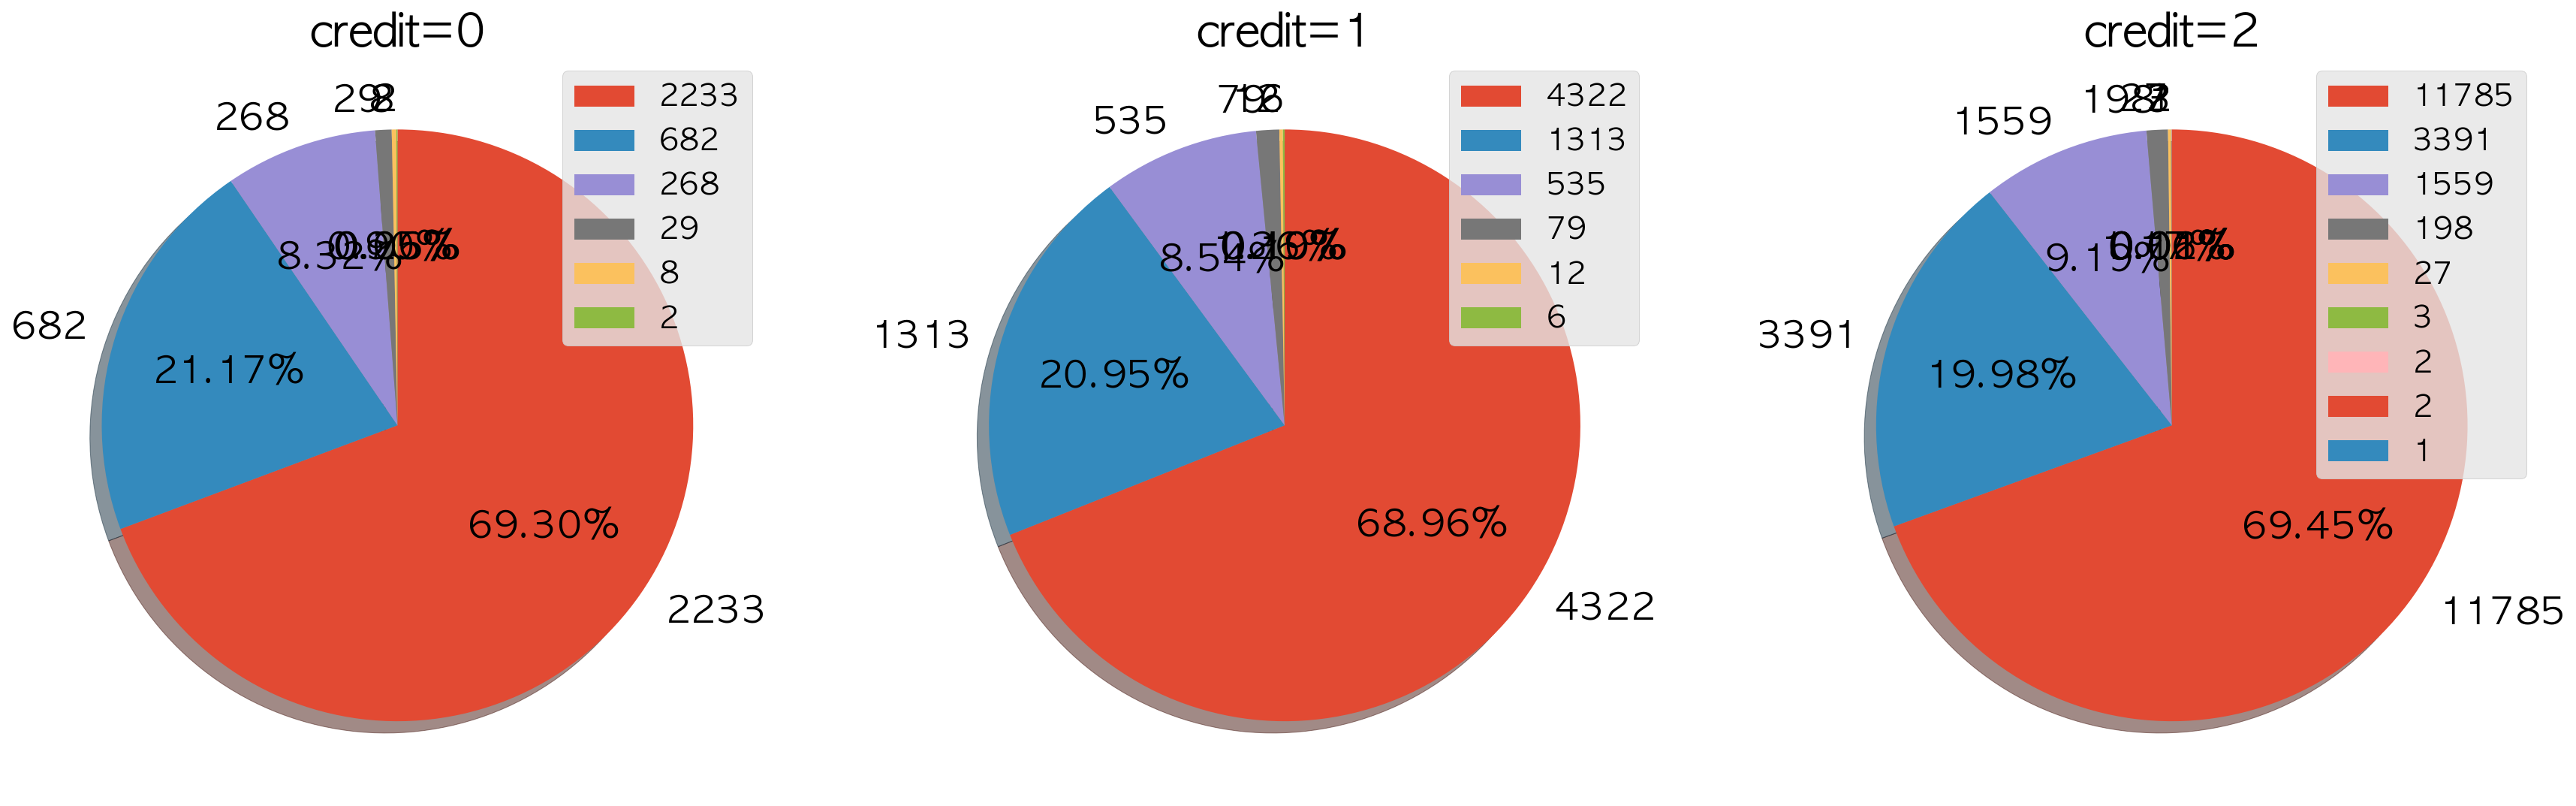

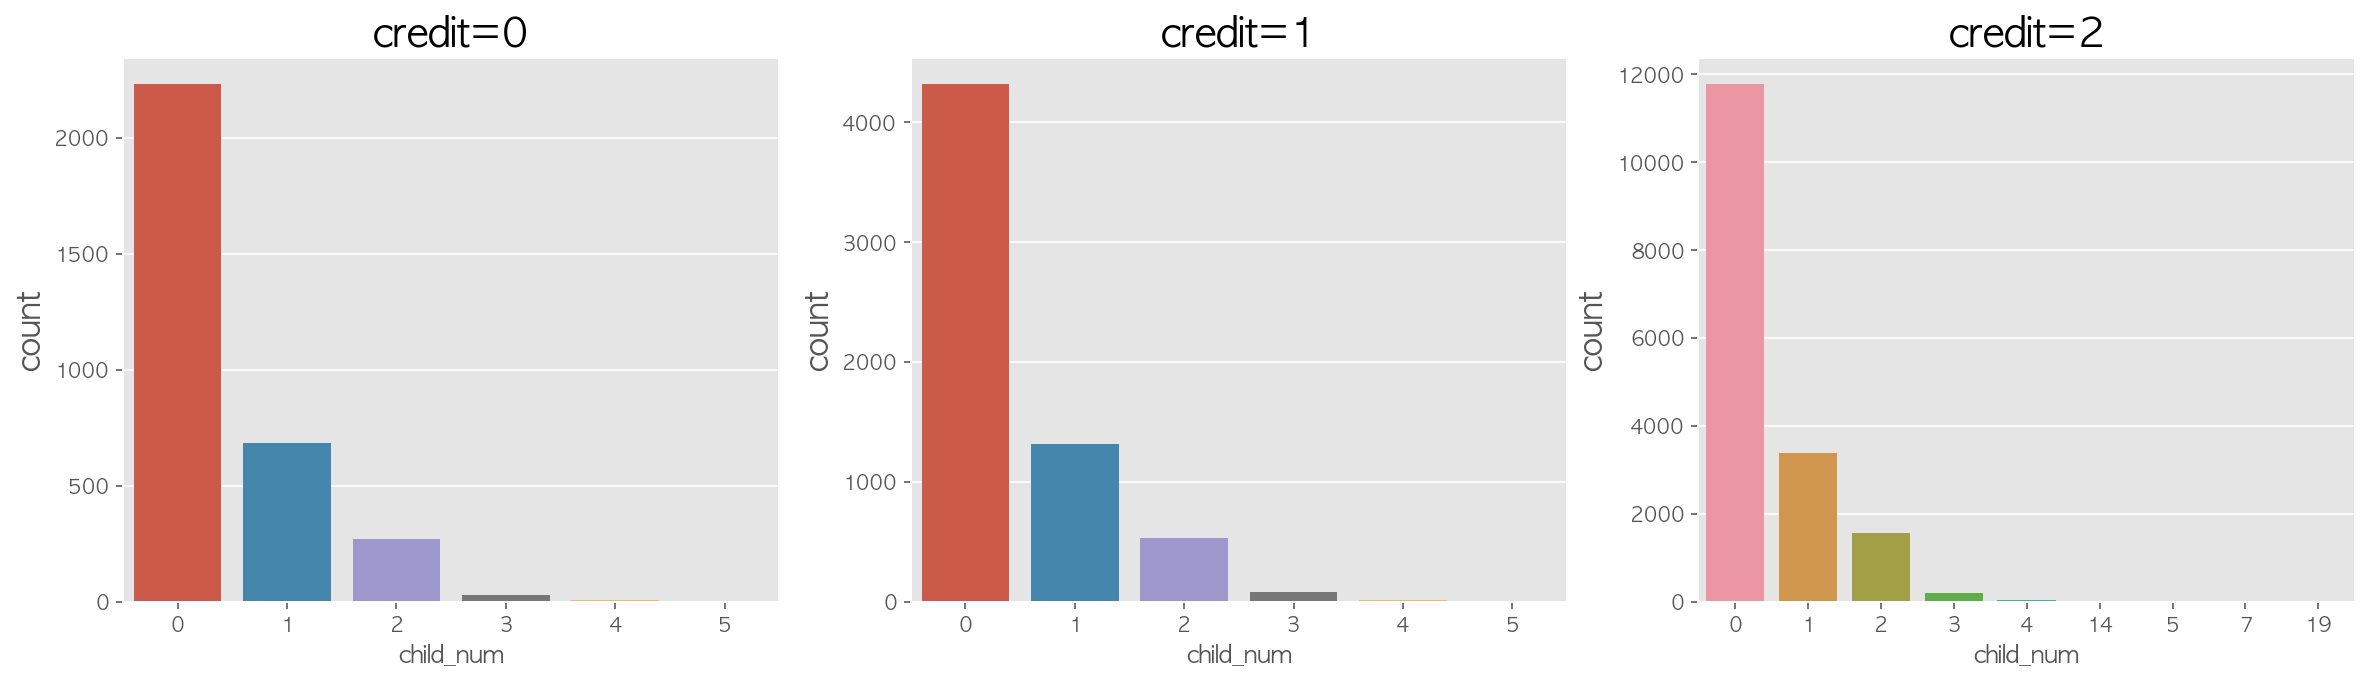

In [30]:
make_plot('child_num')

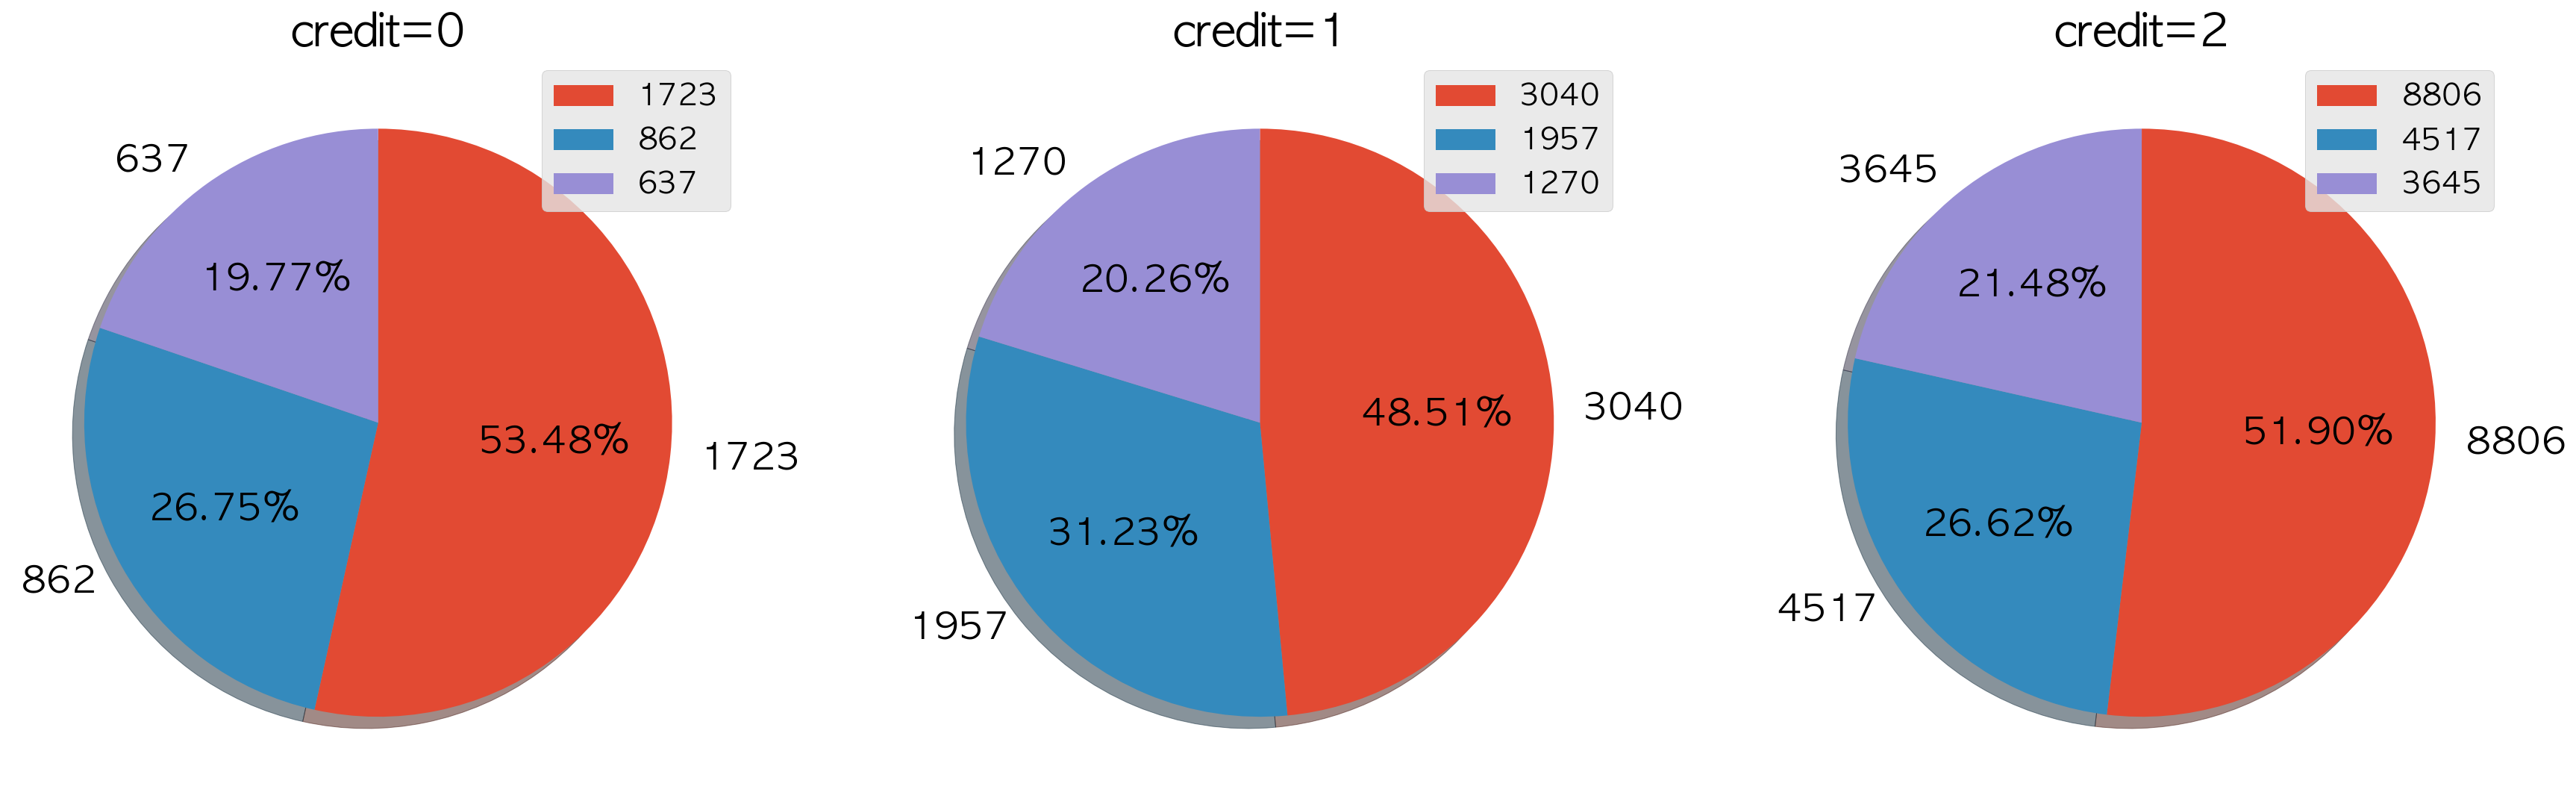

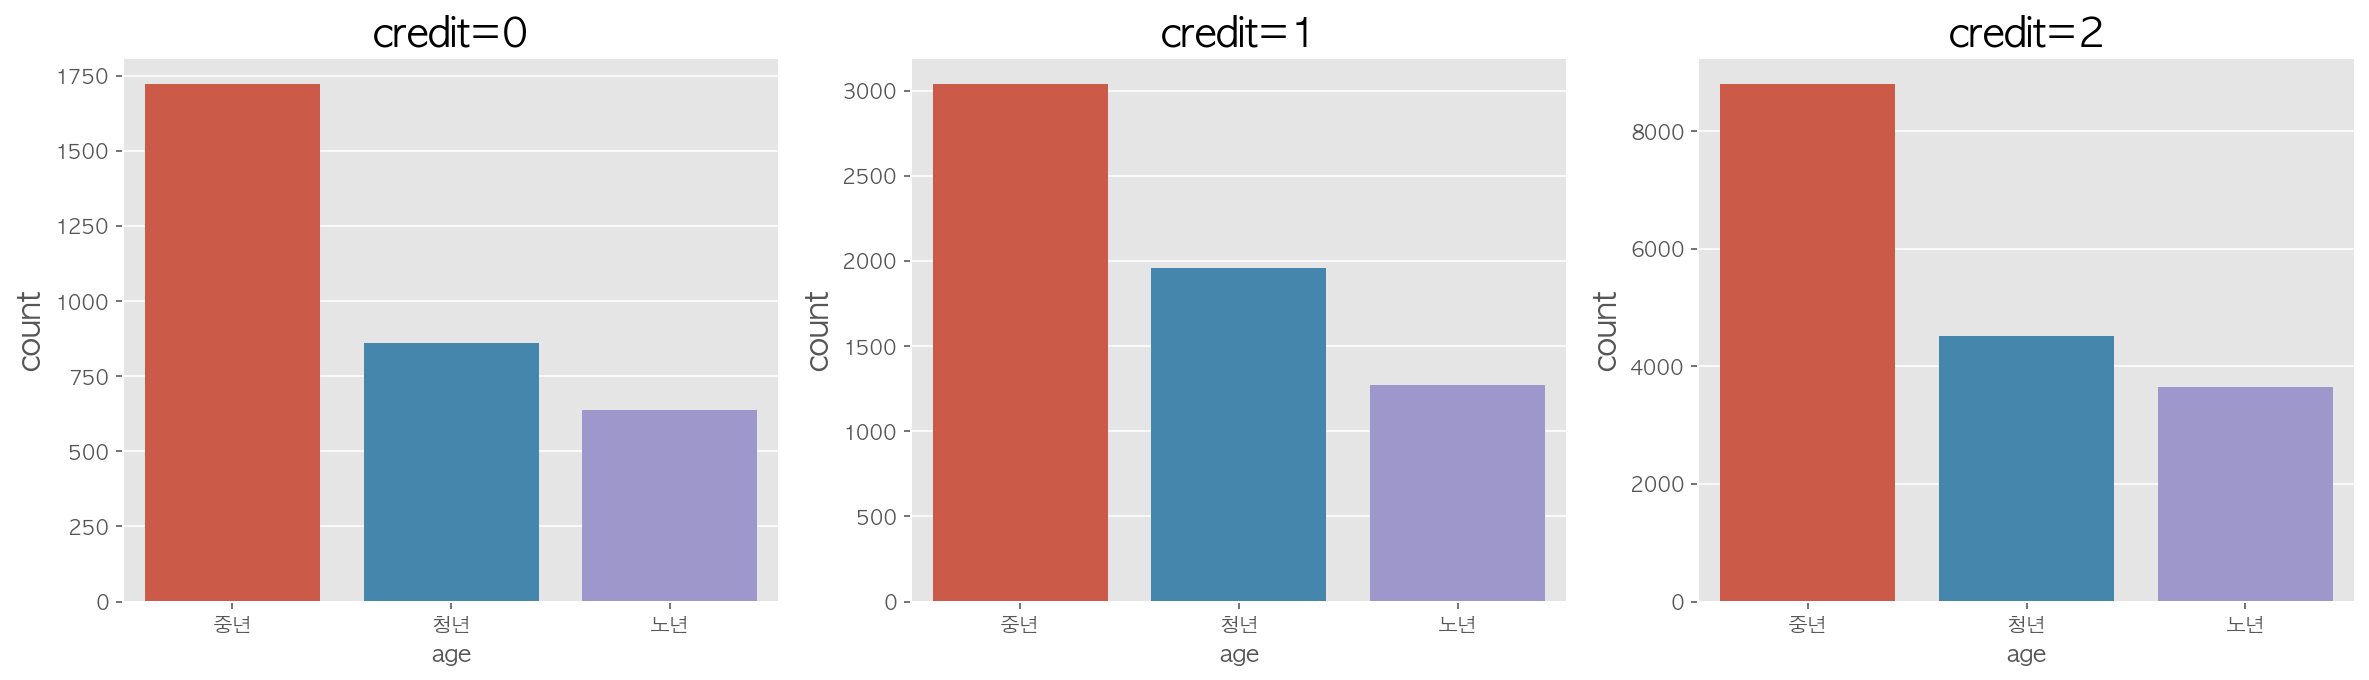

In [31]:
make_plot('age')

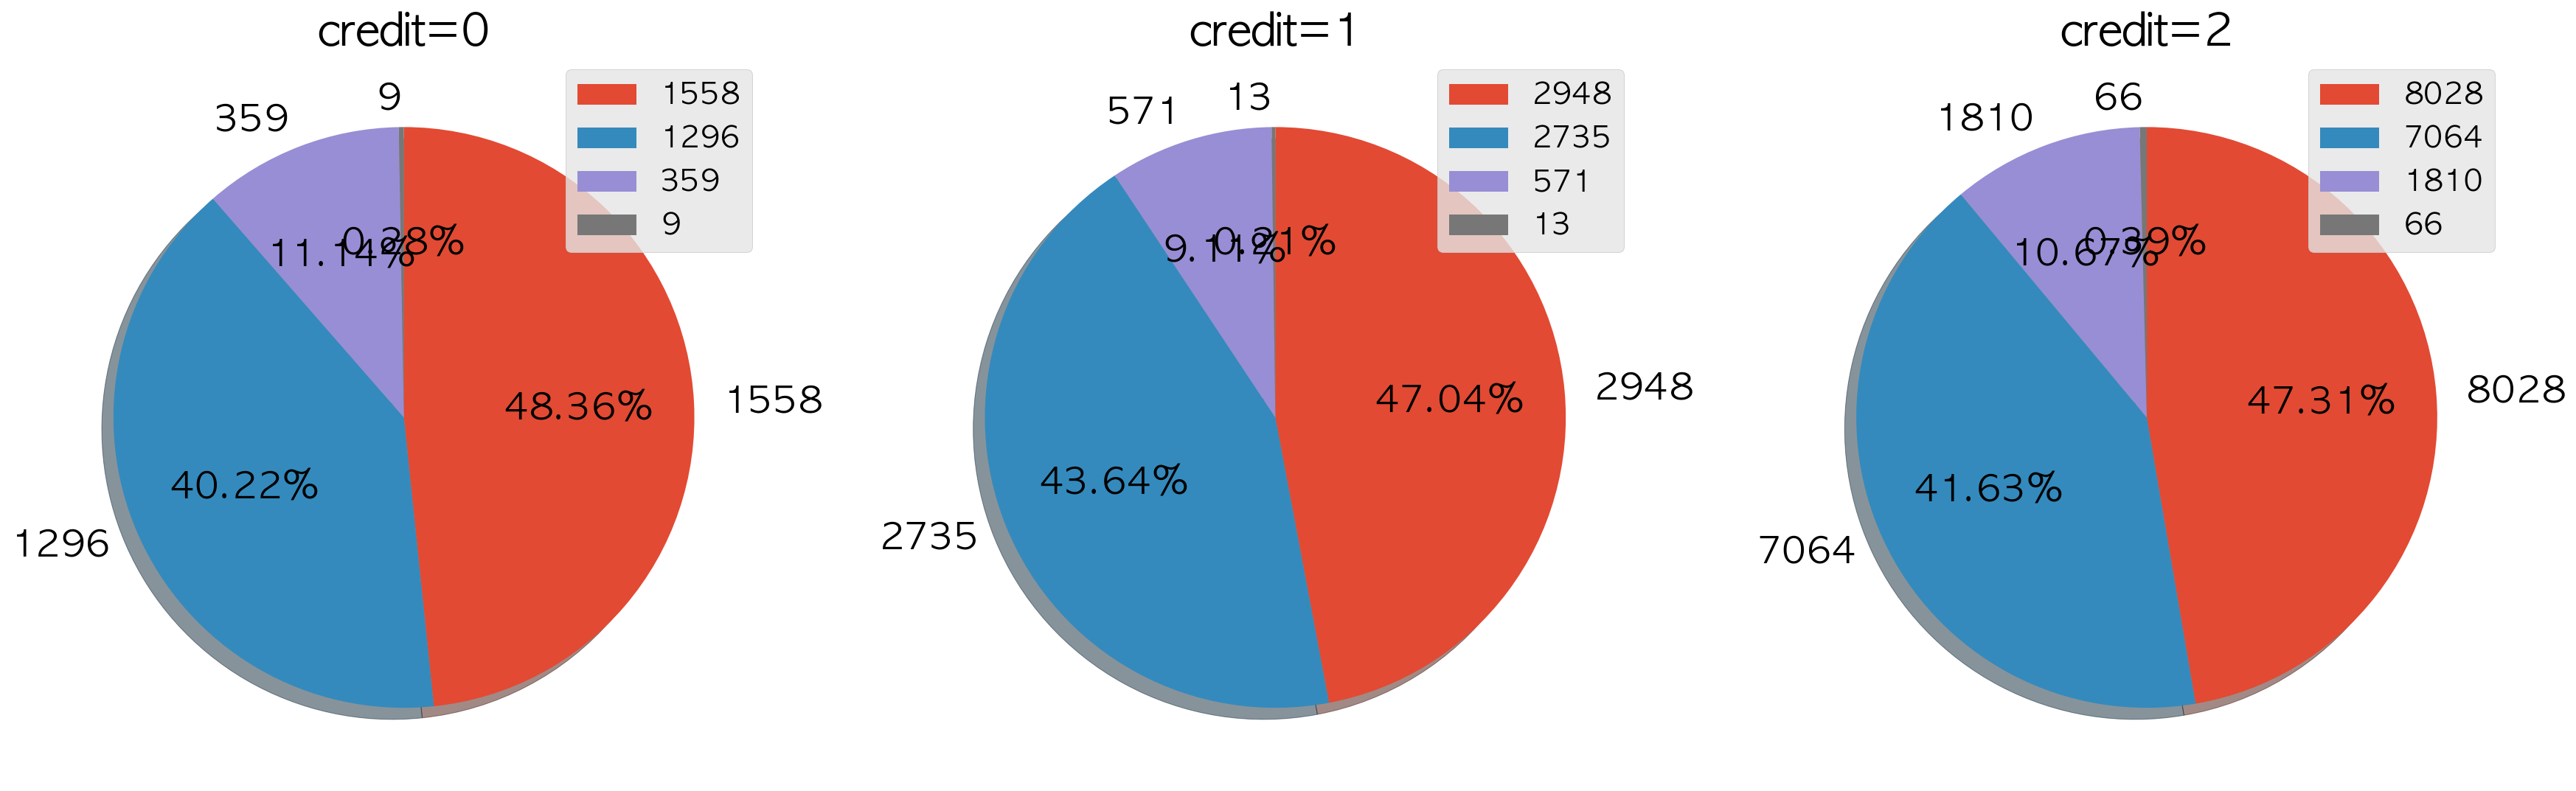

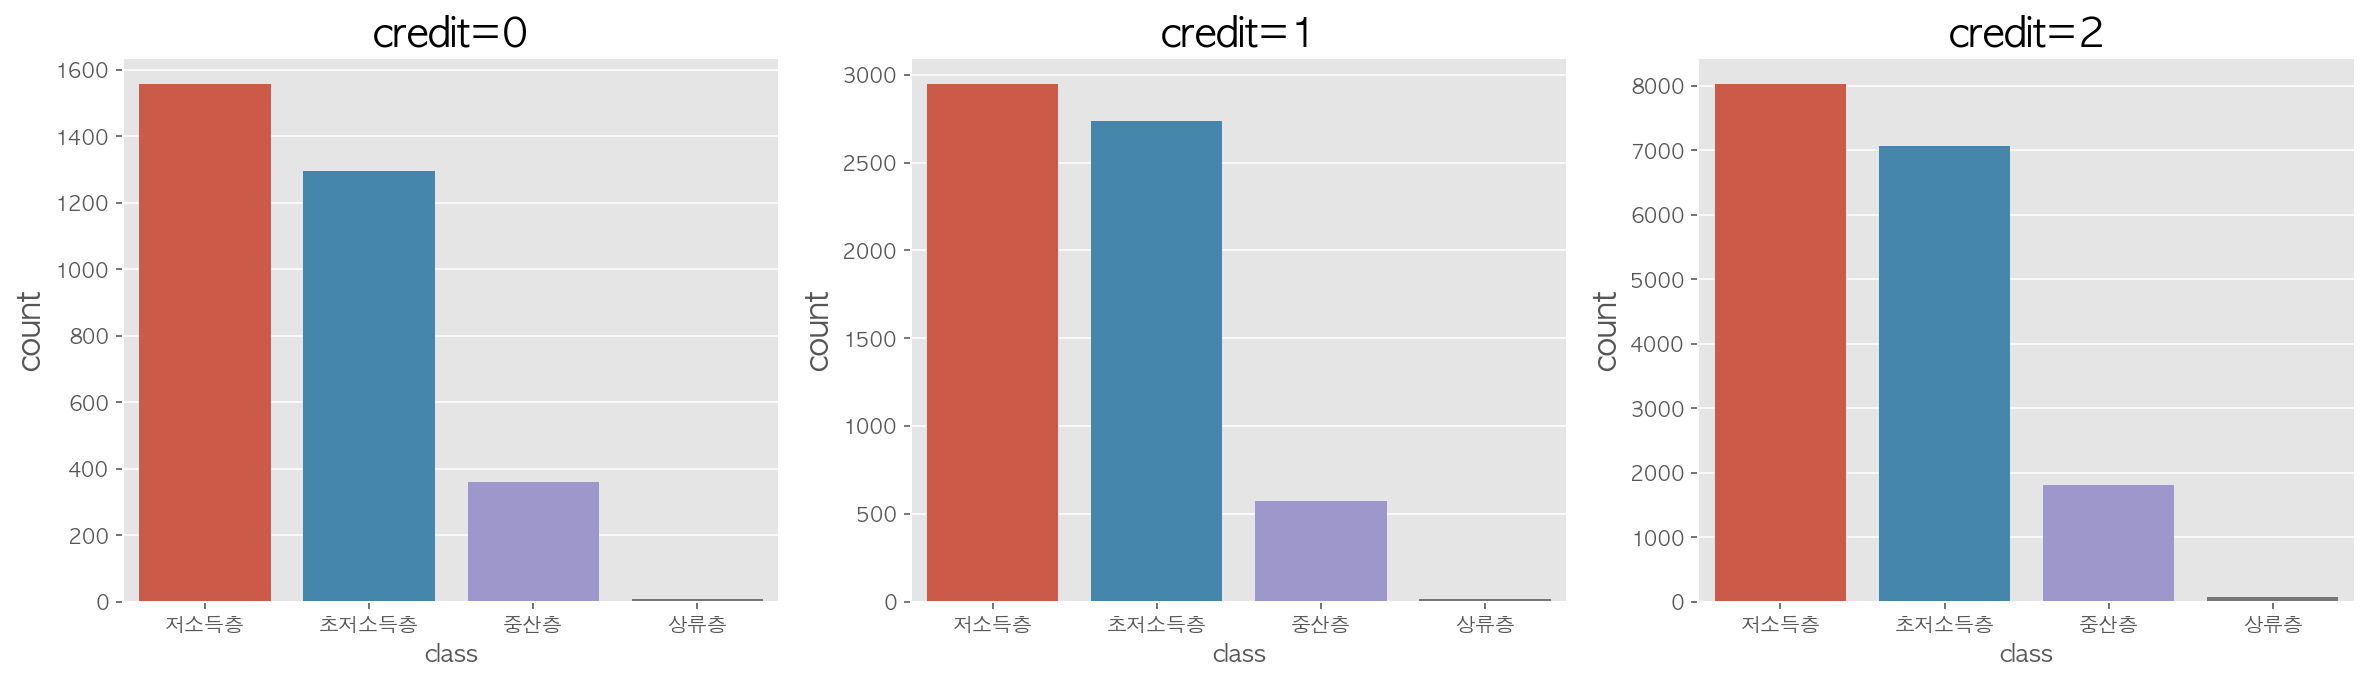

In [32]:
make_plot('class')

In [33]:
data.isnull()

index  gender    car  reality  child_num  income_total  income_type  \
0     False   False  False    False      False         False        False   
1     False   False  False    False      False         False        False   
2     False   False  False    False      False         False        False   
3     False   False  False    False      False         False        False   
4     False   False  False    False      False         False        False   
...     ...     ...    ...      ...        ...           ...          ...   
9995  False   False  False    False      False         False        False   
9996  False   False  False    False      False         False        False   
9997  False   False  False    False      False         False        False   
9998  False   False  False    False      False         False        False   
9999  False   False  False    False      False         False        False   

      edu_type  family_type  house_type  ...  FLAG_MOBIL  work_phone  phone  \
0        False        False       False  ...       False       False  False   
1        False        False       False  ...       False       False  False   
2        False        False       False  ...       False       False  False   
3        False        False       False  ...       False       False  False   
4        False        False       False  ...       False       False  False   
...        ...          ...         ...  ...         ...         ...    ...   
9995     False        False       False  ...       False       False  False   
9996     False        False       False  ...       False       False  False   
9997     False        False       False  ...       False       False  False   
9998     False        False       False  ...       False       False  False   
9999     False        False       False  ...       False       False  False   

      email  occyp_type  family_size  begin_month  credit    age  class  
0     False        True        False        False   False  False  False  
1     False       False        False        False   False  False  False  
2     False       False        False        False   False  False  False  
3     False       False        False        False   False  False  False  
4     False       False        False        False   False  False  False  
...     ...         ...          ...          ...     ...    ...    ...  
9995  False       False        False        False    True  False  False  
9996  False       False        False        False    True  False  False  
9997  False       False        False        False    True  False  False  
9998  False        True        False        False    True  False  False  
9999  False       False        False        False    True  False  False  

[36457 rows x 22 columns]

In [34]:
data.isnull().sum()

index                0
gender               0
car                  0
reality              0
child_num            0
income_total         0
income_type          0
edu_type             0
family_type          0
house_type           0
DAYS_BIRTH           0
DAYS_EMPLOYED        0
FLAG_MOBIL           0
work_phone           0
phone                0
email                0
occyp_type       11323
family_size          0
begin_month          0
credit           10000
age                  0
class                0
dtype: int64

In [35]:
train['credit'].isnull().sum()

0

In [36]:
data = data.drop('occyp_type', axis = 1)

In [37]:
data.isnull().sum()

index                0
gender               0
car                  0
reality              0
child_num            0
income_total         0
income_type          0
edu_type             0
family_type          0
house_type           0
DAYS_BIRTH           0
DAYS_EMPLOYED        0
FLAG_MOBIL           0
work_phone           0
phone                0
email                0
family_size          0
begin_month          0
credit           10000
age                  0
class                0
dtype: int64

In [38]:
unique_len = data.apply(lambda x : len(x.unique()))
unique_len

index            36457
gender               2
car                  2
reality              2
child_num            9
income_total       265
income_type          5
edu_type             5
family_type          5
house_type           6
DAYS_BIRTH        7183
DAYS_EMPLOYED     3640
FLAG_MOBIL           1
work_phone           2
phone                2
email                2
family_size         10
begin_month         61
credit               4
age                  3
class                4
dtype: int64

In [39]:
# nunique를 쓰는게 더 편한 방법
data.nunique()

index            36457
gender               2
car                  2
reality              2
child_num            9
income_total       265
income_type          5
edu_type             5
family_type          5
house_type           6
DAYS_BIRTH        7183
DAYS_EMPLOYED     3640
FLAG_MOBIL           1
work_phone           2
phone                2
email                2
family_size         10
begin_month         61
credit               3
age                  3
class                4
dtype: int64

#### 유니크 값의 갯수에 따라 분류를 해준다
- 2개 이하
- 2개 초과 10개 이하
- 10개 초과

In [40]:
# 유니크 값이 2개 이하인 그룹을 group_1으로 지정
# unique_len[unique_len <=2 ] 
# 이렇게 해주면 유니크 값이 2개 이하인것들의 트루값만 추출
# index 붙이면 index 이름들만 가져올 수 있음
group_1 = unique_len[unique_len <= 2].index
group_1

Index(['gender', 'car', 'reality', 'FLAG_MOBIL', 'work_phone', 'phone',
       'email'],
      dtype='object')

In [41]:
group_2 = unique_len[(unique_len > 2) & (unique_len <=10)].index
group_2

Index(['child_num', 'income_type', 'edu_type', 'family_type', 'house_type',
       'family_size', 'credit', 'age', 'class'],
      dtype='object')

In [42]:
group_3 = unique_len[unique_len > 10].index
group_3

Index(['index', 'income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month'], dtype='object')

#### 머신러닝하려면 0과 1로 바꾸어 주어야하므로 각 그룹별로 바꿔줌

In [43]:
# data안에 그룹들 불러줌
data[group_1]

gender car reality  FLAG_MOBIL  work_phone  phone  email
0         F   N       N           1           0      0      0
1         F   N       Y           1           0      0      1
2         M   Y       Y           1           0      1      0
3         F   N       Y           1           0      1      0
4         F   Y       Y           1           0      0      0
...     ...  ..     ...         ...         ...    ...    ...
9995      F   Y       Y           1           1      1      0
9996      M   Y       Y           1           1      0      0
9997      F   N       Y           1           0      0      0
9998      F   Y       N           1           0      1      0
9999      F   N       Y           1           0      0      1

[36457 rows x 7 columns]

In [44]:
data['gender'].unique()

array(['F', 'M'], dtype=object)

In [45]:
# replace 함수를 활용해서 0과 1로 바꿔줌
data['gender'] = data['gender'].replace(['F', 'M'], [0, 1])
data['car'] = data['car'].replace(['N', 'Y'], [0, 1])
data['reality'] = data['reality'].replace(['N', 'Y'], [0, 1])

In [46]:
data[group_1]

gender  car  reality  FLAG_MOBIL  work_phone  phone  email
0          0    0        0           1           0      0      0
1          0    0        1           1           0      0      1
2          1    1        1           1           0      1      0
3          0    0        1           1           0      1      0
4          0    1        1           1           0      0      0
...      ...  ...      ...         ...         ...    ...    ...
9995       0    1        1           1           1      1      0
9996       1    1        1           1           1      0      0
9997       0    0        1           1           0      0      0
9998       0    1        0           1           0      1      0
9999       0    0        1           1           0      0      1

[36457 rows x 7 columns]

In [47]:
data[group_2]

child_num           income_type                       edu_type  \
0             0  Commercial associate               Higher education   
1             1  Commercial associate  Secondary / secondary special   
2             0               Working               Higher education   
3             0  Commercial associate  Secondary / secondary special   
4             0         State servant               Higher education   
...         ...                   ...                            ...   
9995          0               Working              Incomplete higher   
9996          0               Working  Secondary / secondary special   
9997          0               Working  Secondary / secondary special   
9998          0  Commercial associate  Secondary / secondary special   
9999          0               Working               Higher education   

         family_type           house_type  family_size  credit age class  
0            Married  Municipal apartment            2       1  중년  저소득층  
1     Civil marriage    House / apartment            3       1  청년  저소득층  
2            Married    House / apartment            2       2  중년   중산층  
3            Married    House / apartment            2       0  중년  저소득층  
4            Married    House / apartment            2       2  중년  저소득층  
...              ...                  ...          ...     ...  ..   ...  
9995         Married    House / apartment            2     NaN  중년  저소득층  
9996  Civil marriage    House / apartment            2     NaN  청년  저소득층  
9997         Married    House / apartment            2     NaN  노년  저소득층  
9998         Married    House / apartment            2     NaN  중년  저소득층  
9999         Married    House / apartment            2     NaN  청년  저소득층  

[36457 rows x 9 columns]

<AxesSubplot:>

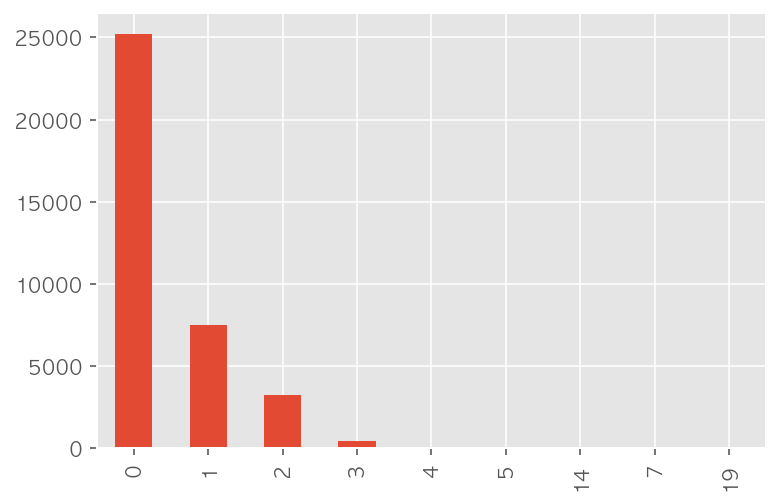

In [48]:
data['child_num'].value_counts().plot.bar()

In [49]:
# 아이의 숫자가 3부터는 너무 적은 양이라서 2로 합쳐준다
data.loc[data['child_num'] > 2, 'child_num'] = 2

<AxesSubplot:>

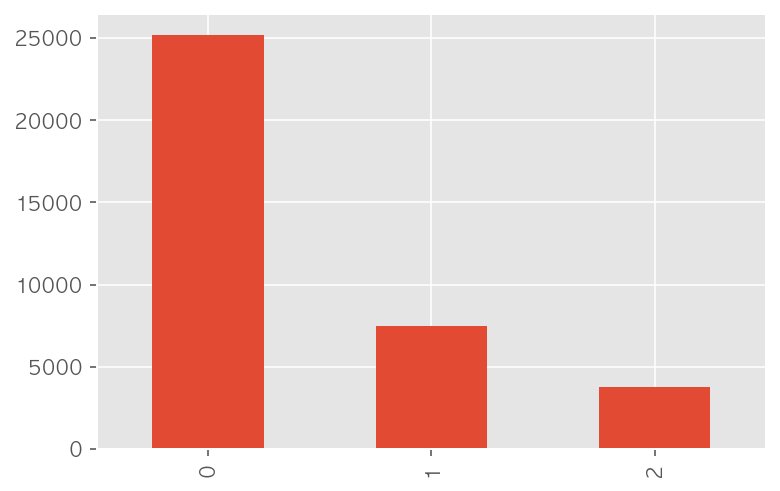

In [50]:
data['child_num'].value_counts().plot.bar()

In [51]:
# group_2에 문자로 되어 있는 컬럼들은 라벨인코딩 처리해줌
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
data['income_type'] = label_encoder.fit_transform(data['income_type'])

In [52]:
# income_type 유니크 값 보고싶다면 set 함수 활용
set(label_encoder.fit_transform(data['income_type']))

{0, 1, 2, 3, 4}

In [53]:
data['edu_type'] = label_encoder.fit_transform(data['edu_type'])
data['family_type'] = label_encoder.fit_transform(data['family_type'])
data['house_type'] = label_encoder.fit_transform(data['house_type'])

In [54]:
data[group_2]

child_num  income_type  edu_type  family_type  house_type  family_size  \
0             0            0         1            1           2            2   
1             1            0         4            0           1            3   
2             0            4         1            1           1            2   
3             0            0         4            1           1            2   
4             0            2         1            1           1            2   
...         ...          ...       ...          ...         ...          ...   
9995          0            4         2            1           1            2   
9996          0            4         4            0           1            2   
9997          0            4         4            1           1            2   
9998          0            0         4            1           1            2   
9999          0            4         1            1           1            2   

      credit age class  
0          1  중년  저소득층  
1          1  청년  저소득층  
2          2  중년   중산층  
3          0  중년  저소득층  
4          2  중년  저소득층  
...      ...  ..   ...  
9995     NaN  중년  저소득층  
9996     NaN  청년  저소득층  
9997     NaN  노년  저소득층  
9998     NaN  중년  저소득층  
9999     NaN  청년  저소득층  

[36457 rows x 9 columns]

In [55]:
# group_3는 요소의 갯수가 많기 때문에, 구간화를 해서 넣어주는게 좋음. 
# 구간을 몇개로 나눌지 알아 보기 위해 bins를 활용해서 확인
np.histogram(data['income_total'], bins=7)
# 7개로 나눠본 어레이 확인

(array([29852,  6071,   413,    96,    11,     6,     8]),
 array([  27000.        ,  248142.85714286,  469285.71428571,
         690428.57142857,  911571.42857143, 1132714.28571429,
        1353857.14285714, 1575000.        ]))

In [56]:
# 8개는 어떨까?
np.histogram(data['income_total'], bins=8)

(array([25713,  9721,   717,   227,    62,     3,     6,     8]),
 array([  27000.,  220500.,  414000.,  607500.,  801000.,  994500.,
        1188000., 1381500., 1575000.]))

In [57]:
# counts와 bin_dividers에 저장해줌
counts, bin_dividers = np.histogram(data['income_total'], bins = 8)

In [58]:
# bin_divider와 pandas의 cut기능을 활용해서 실제 데이터의 값을 수정
pd.cut(data['income_total'], bins = bin_dividers, include_lowest=True, labels = [0,1,2,3,4,5,6,7])
# 첫번째는 값, 두번째는 어느 구간에 들어가있는지 보여줌
# include_lowest를 써야 각 구간의 첫 숫자 값들도 포함 
# labels = [i for i in range(8)] << 이렇게 넣어도 가능

0       0
1       1
2       2
3       0
4       0
       ..
9995    0
9996    0
9997    1
9998    0
9999    1
Name: income_total, Length: 36457, dtype: category
Categories (8, int64): [0 < 1 < 2 < 3 < 4 < 5 < 6 < 7]

In [59]:
# pd.cut 함수가 출력하는 값은 dtype이 카테고리, 
# 시리즈 값과 다르므로 factorize 함수 사용해서 숫자형 int로 바꿔줌
# 1을 주면 카테고리를 보여줌
pd.factorize(pd.cut(data['income_total'], bins = bin_dividers , include_lowest=True, labels = [i for i in range(8)]))[1]


CategoricalIndex([0, 1, 2, 3, 4, 7, 5, 6], categories=[0, 1, 2, 3, 4, 5, 6, 7], ordered=True, dtype='category')

In [60]:
# 0을 주면 int형으로 반환
# pd.factorize(pd.cut(data['income_total'], bins = bin_dividers , include_lowest=True, labels = [i for i in range(8)]))[0]

In [61]:
data['income_total'] = pd.factorize(pd.cut(data['income_total'], bins = bin_dividers , include_lowest=True, labels = [i for i in range(8)]))[0]
data['income_total']

0       0
1       1
2       2
3       0
4       0
       ..
9995    0
9996    0
9997    1
9998    0
9999    1
Name: income_total, Length: 36457, dtype: int64

In [62]:
data[group_3]

index  income_total  DAYS_BIRTH  DAYS_EMPLOYED  begin_month
0         0             0          38             13            6
1         1             1          31              4            5
2         2             2          52             12           22
3         3             0          41              6           37
4         4             0          41              6           26
...     ...           ...         ...            ...          ...
9995  36452             0          51             15           19
9996  36453             0          30              4           34
9997  36454             1          58             38           55
9998  36455             0          45              3           33
9999  36456             1          25              1           11

[36457 rows x 5 columns]

In [63]:
# 위의 방법을 하나의 함수로 만들어주기
# 음수 값들을 양수로 바꿔주기 counts를 사용하지 않을것이기에 _로 바꿔줌
def make_bin(array, n):
    array =  - array
    _, bin_dividers = np.histogram(array, bins = n)
    cut_categories = pd.cut(array, bin_dividers, labels = [i for i in range(n)], include_lowest=True)
    bined_array = pd.factorize(cut_categories)[0]
    return bined_array

In [64]:
pd.Series(make_bin(data['DAYS_BIRTH'], 10)).value_counts()

0    5177
3    5015
1    4922
5    4248
4    4063
2    3934
8    3713
6    3252
9    1252
7     881
dtype: int64

In [65]:
data['DAYS_BIRTH'] = make_bin(data['DAYS_BIRTH'], 10)
data['DAYS_EMPLOYED'] = make_bin(data['DAYS_EMPLOYED'], 10)
data['begin_month'] = make_bin(data['begin_month'], 10)
data

index  gender  car  reality  child_num  income_total  income_type  \
0         0       0    0        0          0             0            0   
1         1       0    0        1          1             1            0   
2         2       1    1        1          0             2            4   
3         3       0    0        1          0             0            0   
4         4       0    1        1          0             0            2   
...     ...     ...  ...      ...        ...           ...          ...   
9995  36452       0    1        1          0             0            4   
9996  36453       1    1        1          0             0            4   
9997  36454       0    0        1          0             1            4   
9998  36455       0    1        0          0             0            0   
9999  36456       0    0        1          0             1            4   

      edu_type  family_type  house_type  ...  DAYS_EMPLOYED  FLAG_MOBIL  \
0            1            1           2  ...              0           1   
1            4            0           1  ...              0           1   
2            1            1           1  ...              0           1   
3            4            1           1  ...              0           1   
4            1            1           1  ...              0           1   
...        ...          ...         ...  ...            ...         ...   
9995         2            1           1  ...              0           1   
9996         4            0           1  ...              0           1   
9997         4            1           1  ...              0           1   
9998         4            1           1  ...              0           1   
9999         1            1           1  ...              0           1   

      work_phone  phone  email  family_size  begin_month  credit  age class  
0              0      0      0            2            0       1   중년  저소득층  
1              0      0      1            3            1       1   청년  저소득층  
2              0      1      0            2            2       2   중년   중산층  
3              0      1      0            2            3       0   중년  저소득층  
4              0      0      0            2            4       2   중년  저소득층  
...          ...    ...    ...          ...          ...     ...  ...   ...  
9995           1      1      0            2            2     NaN   중년  저소득층  
9996           1      0      0            2            8     NaN   청년  저소득층  
9997           0      0      0            2            6     NaN   노년  저소득층  
9998           0      1      0            2            8     NaN   중년  저소득층  
9999           0      0      1            2            0     NaN   청년  저소득층  

[36457 rows x 21 columns]

In [66]:
# train과 test로 data를 나누어 주기

In [67]:
test.shape

(10000, 19)

In [68]:
test = data[-10000:]

In [69]:
train = data[:-10000]

In [70]:
data

index  gender  car  reality  child_num  income_total  income_type  \
0         0       0    0        0          0             0            0   
1         1       0    0        1          1             1            0   
2         2       1    1        1          0             2            4   
3         3       0    0        1          0             0            0   
4         4       0    1        1          0             0            2   
...     ...     ...  ...      ...        ...           ...          ...   
9995  36452       0    1        1          0             0            4   
9996  36453       1    1        1          0             0            4   
9997  36454       0    0        1          0             1            4   
9998  36455       0    1        0          0             0            0   
9999  36456       0    0        1          0             1            4   

      edu_type  family_type  house_type  ...  DAYS_EMPLOYED  FLAG_MOBIL  \
0            1            1           2  ...              0           1   
1            4            0           1  ...              0           1   
2            1            1           1  ...              0           1   
3            4            1           1  ...              0           1   
4            1            1           1  ...              0           1   
...        ...          ...         ...  ...            ...         ...   
9995         2            1           1  ...              0           1   
9996         4            0           1  ...              0           1   
9997         4            1           1  ...              0           1   
9998         4            1           1  ...              0           1   
9999         1            1           1  ...              0           1   

      work_phone  phone  email  family_size  begin_month  credit  age class  
0              0      0      0            2            0       1   중년  저소득층  
1              0      0      1            3            1       1   청년  저소득층  
2              0      1      0            2            2       2   중년   중산층  
3              0      1      0            2            3       0   중년  저소득층  
4              0      0      0            2            4       2   중년  저소득층  
...          ...    ...    ...          ...          ...     ...  ...   ...  
9995           1      1      0            2            2     NaN   중년  저소득층  
9996           1      0      0            2            8     NaN   청년  저소득층  
9997           0      0      0            2            6     NaN   노년  저소득층  
9998           0      1      0            2            8     NaN   중년  저소득층  
9999           0      0      1            2            0     NaN   청년  저소득층  

[36457 rows x 21 columns]

In [71]:
train_x = train.drop(['credit','age','class'], axis=1)

In [72]:
train_y = train['credit']

In [73]:
test_x = test.drop(['credit','age','class'], axis=1)

In [74]:
## random_forest
from sklearn.ensemble import RandomForestClassifier

In [75]:
clf = RandomForestClassifier()

In [76]:
# x에 대한 정보들을보고 해당 row를 y에 만드는 것
clf.fit(train_x, train_y)

RandomForestClassifier()

In [77]:
# train_x를 공부하여 train_y에 대한 예측값, 
# train_y가 3개의 row로 이루어져있다, 0.74 두번째 컬럼이 가장 높은 확률이다.
# 각 row에서 가장 높은 확률만 뽑아내자

train_proba = clf.predict_proba(train_x)
train_proba

array([[0.08, 0.76, 0.16],
       [0.19, 0.63, 0.18],
       [0.04, 0.07, 0.89],
       ...,
       [0.04, 0.16, 0.8 ],
       [0.04, 0.2 , 0.76],
       [0.01, 0.17, 0.82]])

In [78]:
# 가장 높은 확률이 들어 있는 순서 뽑기
np.argmax(train_proba, axis = 1)

array([1, 1, 2, ..., 2, 2, 2])

In [79]:
# 이제 test값에 대한 예측값 확인

clf.predict_proba(test_x)

array([[0.13, 0.23, 0.64],
       [0.14, 0.22, 0.64],
       [0.11, 0.33, 0.56],
       ...,
       [0.04, 0.16, 0.8 ],
       [0.16, 0.33, 0.51],
       [0.13, 0.28, 0.59]])

In [80]:
# 실제 훈련에 사용되는 set과 모델검증에 사용되는 set을 만듭니다.
# stratify는 train_y가 값이 3가지가 나오는데 위에서처럼, 비율을 동일 하게하기위해 train_y로 지정
# 전체 데이터의 25%를 검증으로, 75%를 학습으로 사용
# 보관을 용이하게하기위해 10086으로 설정
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y,
                 stratify = train_y, 
                 test_size=0.25,
                 random_state = 10086
                )

In [81]:
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(19842, 18) (6615, 18) (19842,) (6615,)


In [82]:
clf = RandomForestClassifier()

In [83]:
clf.fit(X_train, y_train)

RandomForestClassifier()

In [84]:
# y_proba는 각 class에 해당하는 확률을 예측한 값
y_proba = clf.predict_proba(X_val)
y_proba

array([[0.08, 0.18, 0.74],
       [0.04, 0.22, 0.74],
       [0.31, 0.1 , 0.59],
       ...,
       [0.16, 0.05, 0.79],
       [0.09, 0.3 , 0.61],
       [0.11, 0.16, 0.73]])

In [85]:
# y_val_onehot은 실제 정답값을 원-핫 인코딩 한 값
y_val_onehot = pd.get_dummies(y_val)
y_val_onehot

0  1  2
36     0  0  1
3464   0  0  1
2640   0  0  1
22500  0  1  0
17275  0  1  0
...   .. .. ..
6806   0  1  0
23096  0  0  1
7756   0  0  1
23331  0  0  1
25457  0  0  1

[6615 rows x 3 columns]

In [86]:
# y_proba가 y_val_onehot과 얼마나 잘 맞는지 확인 log_loss를 활용하여 확인
from sklearn.metrics import log_loss
log_loss(y_val_onehot, y_proba)

0.9146971397470773

In [87]:
# stratify를 위에 넣어줬기때문에 k-fold를 안쓰고 stratifiedKfold 사용
from sklearn.model_selection import StratifiedKFold
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=55)

In [88]:
# index에는 두 가지 array가 존재 하나씩 train과 val에 넣어줌
# index

In [89]:
# train_index, val_index = index

In [90]:
# n_fold를 사용하면 몇번째 폴드인지 확인 할 수 있다
# for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
#    break

In [91]:
# n_fold

In [92]:
# train_x안에 train_index에 해당하는 값만 뽑아서 X_train에 저장
# train_x안에 val_index에 해당하는 값만 뽑아서 저장
outcomes = []
for i, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
    X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
    y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
    
    print(f'========{1+i} Fold ========')
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    
    prediction = clf.predict_proba(X_val)
    y_val_onehot = pd.get_dummies(y_val)
    
    logloss = log_loss(y_val_onehot, prediction)
    
    outcomes.append(logloss)
    
np.mean(outcomes)

========1 Fold ========
========2 Fold ========
========3 Fold ========
========4 Fold ========
========5 Fold ========


0.9282375397171915

In [93]:
# LGBM 사용해보자
import random
from lightgbm import LGBMClassifier

random.seed(42)
lgb_models={}
for i, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
    X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
    y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
    
    print(f'========{1+i} Fold ========')
    lgb = LGBMClassifier(n_estimators=1000)
    lgb.fit(X_train, y_train,
           eval_set=[(X_train, y_train), (X_val, y_val)],
           early_stopping_rounds=30,
           verbose=100)
    lgb_models[i]=lgb

========1 Fold ========
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.72463	valid_1's multi_logloss: 0.827617
Early stopping, best iteration is:
[76]	training's multi_logloss: 0.744165	valid_1's multi_logloss: 0.827282
========2 Fold ========
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[61]	training's multi_logloss: 0.757118	valid_1's multi_logloss: 0.82278
========3 Fold ========
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[58]	training's multi_logloss: 0.759639	valid_1's multi_logloss: 0.826449
========4 Fold ========
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.720246	valid_1's multi_logloss: 0.821357
Early stopping, best iteration is:
[116]	training's multi_logloss: 0.707993	valid_1's multi_logloss: 0.821227
========5 Fold ========
Training until validation scores don't improve for 